### Development of a score based on the gaussian heatmaps 
This can be used to generate the 'ground truth' score of the heatmaps produced from the Contextual layer , which will be compared with the score produced from the FCN heatmaps layer. 

- First we generate the heatmaps, and also visually cehck them. 
- the we pass the heatmaps to the routine that prodcues the scores 


## Build MRCNN model

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os, sys, math, io, time, gc, argparse, platform, pprint
import numpy as np
import tensorflow as tf
import keras
import keras.backend as KB
sys.path.append('../')
import mrcnn.model_mrcnn  as mrcnn_modellib
import mrcnn.model_fcn    as fcn_modellib
import mrcnn.visualize    as visualize
import mrcnn.new_shapes   as shapes
import mrcnn.utils        as utils

from datetime           import datetime   
from mrcnn.utils        import command_line_parser, Paths
from mrcnn.config       import Config
from mrcnn.dataset      import Dataset 

# from mrcnn.utils        import log, stack_tensors, stack_tensors_3d, write_stdout
# from mrcnn.datagen      import data_generator, load_image_gt, data_gen_simulate
from mrcnn.datagen_fcn  import fcn_data_gen_simulate
from mrcnn.callbacks    import get_layer_output_1,get_layer_output_2
# from mrcnn.coco         import CocoDataset, CocoInferenceConfig, evaluate_coco, build_coco_results
from mrcnn.coco         import CocoConfig
# from mrcnn.heatmap      import HeatmapDataset
from mrcnn.prep_notebook import prep_heatmap_dataset, prep_coco_dataset

pp = pprint.PrettyPrinter(indent=2, width=100)
np.set_printoptions(linewidth=100,precision=4,threshold=1000, suppress = True)
start_time = datetime.now().strftime("%m-%d-%Y @ %H:%M:%S")
print()
print('--> Execution started at:', start_time)
print("    Tensorflow Version: {}   Keras Version : {} ".format(tf.__version__,keras.__version__))

####  Pass input parameters to argparse

# args = parser.parse_args("--epochs 100 --steps_in_epoch 128  --last_epoch 1264 --batch_size 8  --lr 0.5               --logs_dir train_fcn_adagrad --model /home/kbardool/models/train_mrcnn/shapes20180621T1554/mask_rcnn_shapes_1119.h5 --fcn_model init".split())
# input_parms = "--epochs 100 --steps_in_epoch 100  --last_epoch 1264 --batch_size 25 --lr 0.8 --val_steps 5 --logs_dir train_fcn_adagrad --model /home/kbardool/models/train_mrcnn/shapes20180621T1554/mask_rcnn_shapes_1119.h5 --fcn_model /home/kbardool/models/train_fcn_adagrad/shapes20180709T1732/fcn_shapes_1167.h5"
# input_parms +=" --model     /home/kbardool/models/train_mrcnn/shapes20180621T1554/mask_rcnn_shapes_1119.h5 "
##------------------------------------------------------------------------------------
## Parse command line arguments
##------------------------------------------------------------------------------------
parser = command_line_parser()
input_parms = "--epochs 2 --steps_in_epoch 32  --last_epoch 0 --batch_size 2 --lr 0.00001 --val_steps 8 " 
# input_parms +="--mrcnn_logs_dir train_mrcnn_newshapes "
# input_parms +="--fcn_logs_dir   train_fcn8_newshapes "
input_parms +="--mrcnn_logs_dir train_mrcnn_coco "
input_parms +="--fcn_logs_dir   train_fcn8_coco_adam "
input_parms +="--mrcnn_model    last "
input_parms +="--fcn_model      init "
input_parms +="--opt            adagrad "
input_parms +="--fcn_arch       fcn8 " 
input_parms +="--fcn_layers     all " 
input_parms +="--sysout        screen "
input_parms +="--new_log_folder    "
# input_parms +="--fcn_model /home/kbardool/models/train_fcn_adagrad/shapes20180709T1732/fcn_shapes_1167.h5"
print(input_parms)

args = parser.parse_args(input_parms.split())
# args = parser.parse_args()

##----------------------------------------------------------------------------------------------
## if debug is true set stdout destination to stringIO
##----------------------------------------------------------------------------------------------            
# debug = False
if args.sysout == 'FILE':
    sys.stdout = io.StringIO()

# print("    Dataset            : ", args.dataset)
# print("    Logs               : ", args.logs)
# print("    Limit              : ", args.limit)
print("    MRCNN Model        : ", args.mrcnn_model)
print("    FCN Model          : ", args.fcn_model)
print("    MRCNN Log Dir      : ", args.mrcnn_logs_dir)
print("    FCN Log Dir        : ", args.fcn_logs_dir)
print("    FCN Arch           : ", args.fcn_arch)
print("    FCN Log Dir        : ", args.fcn_layers)
print("    Last Epoch         : ", args.last_epoch)
print("    Epochs to run      : ", args.epochs)
print("    Steps in each epoch: ", args.steps_in_epoch)
print("    Validation steps   : ", args.val_steps)
print("    Batch Size         : ", args.batch_size)
print("    Optimizer          : ", args.opt)
print("    sysout             : ", args.sysout)
# print("    OS Platform        : ", syst)

##------------------------------------------------------------------------------------
## setup project directories
##   ROOT_DIR         : Root directory of the project 
##   MODEL_DIR        : Directory to save logs and trained model
##   COCO_MODEL_PATH  : Path to COCO trained weights
##---------------------------------------------------------------------------------
paths = Paths(fcn_training_folder = args.fcn_logs_dir, mrcnn_training_folder = args.mrcnn_logs_dir)
paths.display()

### Build Configuration Object

##------------------------------------------------------------------------------------
## Build configuration object 
##------------------------------------------------------------------------------------                          
mrcnn_config                    = CocoConfig()
mrcnn_config.NAME               = 'mrcnn'              
mrcnn_config.TRAINING_PATH      = paths.MRCNN_TRAINING_PATH
mrcnn_config.COCO_DATASET_PATH  = paths.COCO_DATASET_PATH 
mrcnn_config.COCO_MODEL_PATH    = paths.COCO_MODEL_PATH   
mrcnn_config.RESNET_MODEL_PATH  = paths.RESNET_MODEL_PATH 
mrcnn_config.VGG16_MODEL_PATH   = paths.VGG16_MODEL_PATH  
mrcnn_config.COCO_CLASSES       = None 
mrcnn_config.DETECTION_PER_CLASS = 200
mrcnn_config.HEATMAP_SCALE_FACTOR = 4
mrcnn_config.BATCH_SIZE         = int(args.batch_size)                  # Batch size is 2 (# GPUs * images/GPU).
mrcnn_config.IMAGES_PER_GPU     = int(args.batch_size)                  # Must match BATCH_SIZE

mrcnn_config.STEPS_PER_EPOCH    = int(args.steps_in_epoch)
mrcnn_config.LEARNING_RATE      = float(args.lr)
mrcnn_config.EPOCHS_TO_RUN      = int(args.epochs)
mrcnn_config.FCN_INPUT_SHAPE    = mrcnn_config.IMAGE_SHAPE[0:2]
mrcnn_config.LAST_EPOCH_RAN     = int(args.last_epoch)
mrcnn_config.NEW_LOG_FOLDER       = True
mrcnn_config.SYSOUT               = args.sysout

# mrcnn_config.WEIGHT_DECAY       = 2.0e-4
# mrcnn_config.VALIDATION_STEPS   = int(args.val_steps)
# mrcnn_config.REDUCE_LR_FACTOR   = 0.5
# mrcnn_config.REDUCE_LR_COOLDOWN = 30
# mrcnn_config.REDUCE_LR_PATIENCE = 40
# mrcnn_config.EARLY_STOP_PATIENCE= 80
# mrcnn_config.EARLY_STOP_MIN_DELTA = 1.0e-4
# mrcnn_config.MIN_LR             = 1.0e-10
# mrcnn_config.OPTIMIZER          = args.opt.upper()

# mrcnn_config.display() 


###  Build Model

from mrcnn.prep_notebook import mrcnn_coco_train
mrcnn_model, mrcnn_config = mrcnn_coco_train(mode = 'training', mrcnn_config = mrcnn_config)

Using TensorFlow backend.



--> Execution started at: 11-16-2018 @ 12:21:05
    Tensorflow Version: 1.8.0   Keras Version : 2.2.0 
--epochs 2 --steps_in_epoch 32  --last_epoch 0 --batch_size 2 --lr 0.00001 --val_steps 8 --mrcnn_logs_dir train_mrcnn_coco --fcn_logs_dir   train_fcn8_coco_adam --mrcnn_model    last --fcn_model      init --opt            adagrad --fcn_arch       fcn8 --fcn_layers     all --sysout        screen --new_log_folder    
    MRCNN Model        :  last
    FCN Model          :  init
    MRCNN Log Dir      :  train_mrcnn_coco
    FCN Log Dir        :  train_fcn8_coco_adam
    FCN Arch           :  FCN8
    FCN Log Dir        :  ['all']
    Last Epoch         :  0
    Epochs to run      :  2
    Steps in each epoch:  32
    Validation steps   :  8
    Batch Size         :  2
    Optimizer          :  ADAGRAD
    sysout             :  SCREEN
>>> Initialize Paths
 windows  Windows

Paths:
-------------------------
COCO_DATASET_PATH              F:\MLDatasets\coco2014
COCO_HEATMAP_PATH          

    X/Y shapes : (256, 256) (256, 256)
    Ones:     (?, 1, 1)
    ones_exp * X (?, 1, 1) * (256, 256) =  (?, 256, 256)
    ones_exp * Y (?, 1, 1) * (256, 256) =  (?, 256, 256)
    pos_grid before transpse :  (?, 256, 256, 2)
    pos_grid after transpose :  (256, 256, ?, 2)
    >> input to MVN.PROB: pos_grid (meshgrid) shape:  (256, 256, ?, 2)
     Prob_grid shape from mvn.probe:  (256, 256, ?)
     Prob_grid shape after tanspose:  (?, 256, 256)
    << output probabilities shape  :  (?, 256, 256)
    scores_scattered shape :  (2, 81, 200, 3)
    gauss_scores  (FINAL)  :  (2, 81, 200, 11)  Keras tensor  False

    normalization ------------------------------------------------------
    normalizer     :  (?, 1, 1)
    prob_grid_norm_scaled :  (?, 256, 256)

    Scatter out the probability distributions based on class --------------
    pt2_ind shape      :  (?, 3)
    prob_grid_clippped :  (?, 256, 256)
    gauss_heatmap      :  (2, 81, 200, 256, 256)

    Reduce sum based on class -----

##  Build FCN Model 

In [2]:
##------------------------------------------------------------------------------------
## Build configuration for FCN model
##------------------------------------------------------------------------------------
fcn_config = CocoConfig()
fcn_config.COCO_DATASET_PATH  = paths.COCO_DATASET_PATH 
fcn_config.COCO_HEATMAP_PATH  = paths.COCO_HEATMAP_PATH 

# mrcnn_config.COCO_MODEL_PATH    = COCO_MODEL_PATH   
# mrcnn_config.RESNET_MODEL_PATH  = RESNET_MODEL_PATH 
fcn_config.NAME                 = 'fcn'              
fcn_config.TRAINING_PATH        = paths.FCN_TRAINING_PATH
fcn_config.VGG16_MODEL_PATH     = paths.FCN_VGG16_MODEL_PATH
fcn_config.HEATMAP_SCALE_FACTOR = 4
fcn_config.FCN_INPUT_SHAPE      = fcn_config.IMAGE_SHAPE[0:2] // fcn_config.HEATMAP_SCALE_FACTOR 

fcn_config.BATCH_SIZE           = int(args.batch_size)                 # Batch size is 2 (# GPUs * images/GPU).
fcn_config.IMAGES_PER_GPU       = int(args.batch_size)                   # Must match BATCH_SIZE
fcn_config.EPOCHS_TO_RUN        = int(args.epochs)
fcn_config.STEPS_PER_EPOCH      = int(args.steps_in_epoch)
fcn_config.LAST_EPOCH_RAN       = int(args.last_epoch)

fcn_config.LEARNING_RATE        = float(args.lr)

fcn_config.VALIDATION_STEPS     = int(args.val_steps)
fcn_config.BATCH_MOMENTUM       = 0.9
fcn_config.WEIGHT_DECAY         = 2.0e-4

fcn_config.REDUCE_LR_FACTOR     = 0.5
fcn_config.REDUCE_LR_COOLDOWN   = 5
fcn_config.REDUCE_LR_PATIENCE   = 5
fcn_config.EARLY_STOP_PATIENCE  = 15
fcn_config.EARLY_STOP_MIN_DELTA = 1.0e-4
fcn_config.MIN_LR               = 1.0e-10
 
fcn_config.NEW_LOG_FOLDER       = args.new_log_folder
fcn_config.OPTIMIZER            = args.opt
fcn_config.SYSOUT               = args.sysout

fcn_config.display()


Configuration Parameters:
-------------------------
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_MOMENTUM                 0.9
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COCO_DATASET_PATH              F:\MLDatasets\coco2014
COCO_HEATMAP_PATH              F:\MLDatasets\coco2014_heatmaps
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
DETECTION_PER_CLASS            200
EARLY_STOP_MIN_DELTA           0.0001
EARLY_STOP_PATIENCE            15
EPOCHS_TO_RUN                  2
FCN_INPUT_SHAPE                [256 256]
GPU_COUNT                      1
HEATMAP_SCALE_FACTOR           4
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LAST_EPOCH_RAN                 0
LEA

In [47]:
#### Build Model
##------------------------------------------------------------------------------------
## Build FCN Model in Training Mode
##------------------------------------------------------------------------------------
try :
    del fcn_model
    gc.collect()
except: 
    pass    
fcn_model = fcn_modellib.FCN(mode="training", arch = 'FCN8', config=fcn_config)

####  Display FCN model info
# fcn_model.config.display()  
fcn_model.layer_info()

>>> Initialize ModelBase model 
   Mode      :  training
   Model dir :  F:\models\train_fcn8_coco_adam
>>> ModelBase initialiation complete
>>> Initialize FCN model, mode:  training architecture:  FCN8
>>> set_log_dir(): model_path:  None
    set_log_dir(): model_path has NOT been provided : None 
                  NewFolder: False  config.NEW_LOG_FOLDER: True 
    set_log_dir(): weight file template (self.checkpoint_path): F:\models\train_fcn8_coco_adam\fcn20181116T1349\fcn_{epoch:04d}.h5 
    set_log_dir(): weight file dir      (self.log_dir)        : F:\models\train_fcn8_coco_adam\fcn20181116T1349 
    set_log_dir(): Last completed epoch (self.epoch)          : 0 
    arch set to FCN8 - with No L2 Regularization
<function fcn8_graph at 0x00000015307EF158>
 Parse Image Meta Graph 
     meta :  <class 'tensorflow.python.framework.ops.Tensor'> (None, None)
 Parse Image Meta Graph 
     meta :  <class 'tensorflow.python.framework.ops.Tensor'> (None, None)
   active_class_ids  shape is 

##  Load Model Weights

In [4]:
# exclude=["mrcnn_class_logits"] # ,"mrcnn_bbox_fc"]   #, "mrcnn_bbox", "mrcnn_mask"])
mrcnn_model.load_model_weights(init_with = 'last', exclude = None)  

-----------------------------------------------
 Load Model with init parm: [ last ]
-----------------------------------------------
 ---> last
>>> find_last checkpoint in :  F:\models\train_mrcnn_coco
    Dir starting with  mrcnn  : ['mrcnn20181011T1100', 'mrcnn20181024T2023', 'mrcnn20181111T1438', 'mrcnn20181111T1441', 'mrcnn20181112T1039', 'mrcnn20181112T1531', 'mrcnn20181113T1636', 'mrcnn20181113T1654', 'mrcnn20181113T2154', 'mrcnn20181113T2235', 'mrcnn20181113T2259', 'mrcnn20181114T1203', 'mrcnn20181114T1204', 'mrcnn20181114T1454', 'mrcnn20181115T1017', 'mrcnn20181115T1041', 'mrcnn20181115T1114', 'mrcnn20181115T1259', 'mrcnn20181115T1503', 'mrcnn20181115T1645', 'mrcnn20181115T2042', 'mrcnn20181115T2159', 'mrcnn20181116T1221']
    find_last():   dir_name: F:\models\train_mrcnn_coco\mrcnn20181011T1100
    find_last(): checkpoint: F:\models\train_mrcnn_coco\mrcnn20181011T1100\mrcnn_0103.h5
>>> load_weights() from : F:\models\train_mrcnn_coco\mrcnn20181011T1100\mrcnn_0103.h5
layers ty

In [48]:
#### FCN

##------------------------------------------------------------------------------------
## Load FCN Model weights  
##------------------------------------------------------------------------------------
# fcn_model.load_model_weights(init_with = 'last') # 'fcn_config.VGG16_MODEL_PATH')
# WEIGHT_FILE = '/home/kbardool/models/train_fcn8_coco/fcn20181028T0000/fcn_0050.h5'  # <--- With L2
# WEIGHT_FILE = '/home/kbardool/models/train_fcn8_coco/fcn20181030T0000/fcn_0248.h5' # <--- Partial L2 (some still remaining)
# WEIGHT_FILE = '/home/kbardool/models/train_fcn8_coco/fcn20181031T0000/fcn_0156.h5'
WEIGHT_FILE = 'F:/models/train_fcn8_coco_adam/fcn20181109T0000/fcn_1569.h5'
fcn_model.load_model_weights(init_with = WEIGHT_FILE)


-----------------------------------------------
 Load Model with init parm: [ F:/models/train_fcn8_coco_adam/fcn20181109T0000/fcn_1569.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : F:/models/train_fcn8_coco_adam/fcn20181109T0000/fcn_1569.h5
layers type:  <class 'list'> length:  41
    Weights file loaded: F:/models/train_fcn8_coco_adam/fcn20181109T0000/fcn_1569.h5 
FCN  MODEL Load weight file COMPLETE 


## Build Training & Validation Datasets

In [6]:
dataset_train, train_generator= prep_coco_dataset(['train'], fcn_config, generator = True,shuffle = False)
# dataset_train, train_generator= prep_coco_dataset(['train','val35k'], fcn_config, generator = True,shuffle = False)
# dataset_val, val_generator    = prep_coco_dataset(['minival'], fcn_config, generator = True, shuffle = False)

dataset_train.image_ids[:20]
# for i in dataset_train.image_ids[:100]:
#     print(i, ' coco id ', dataset_train.image_info[i]['id'])

Kevin loading annotations file F:\MLDatasets\coco2014\annotations/instances_train2014.json  into memory...
Done (t=18.96s)
creating index...
index created!
 image dir            :  F:\MLDatasets\coco2014\train2014
 json_path_dir        :  F:\MLDatasets\coco2014\annotations/instances_train2014.json
 number of images     :  82081
 image_ids[:10]       :  [262145, 262146, 524291, 131074, 393221, 131075, 393223, 393224, 524297, 9]
 image_ids[1000:1010] :  [1451, 132523, 1453, 132527, 263599, 132529, 132528, 263603, 263604, 132533]


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

## Display Images

###  Display image with Ground Truth bounding boxes and masks

In [9]:
train_batch_x, train_batch_y = next(train_generator)
# for i in train_batch_x:
#     print(i.shape)

D:\Program Files\Anaconda3\envs\TF\lib\site-packages\scipy\ndimage\interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


####  Display next image from generator

Image id:  2
Image meta [   2  426  640    3  171    0  853 1024    1    1]


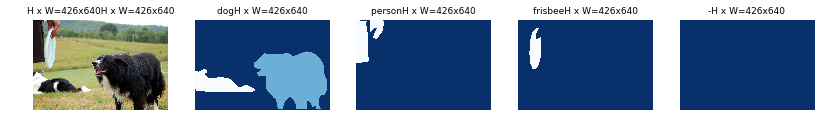

Image id:  3
Image meta [   3  428  640    3  169    0  854 1024    1    1]


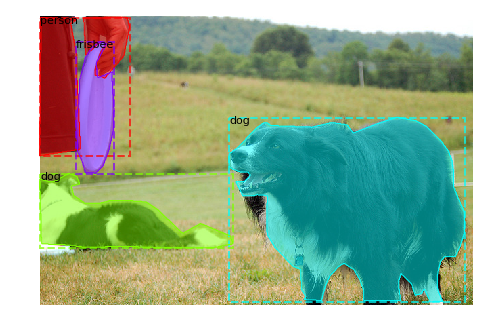

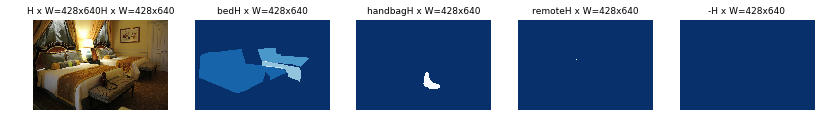

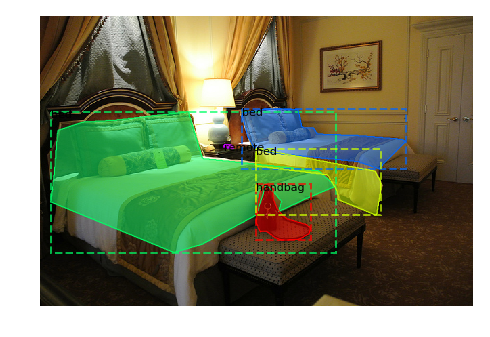

In [49]:
imgmeta_idx = mrcnn_model.keras_model.input_names.index('input_image_meta')
img_meta    = train_batch_x[imgmeta_idx]

for img_idx in range(mrcnn_config.BATCH_SIZE):
    image_id = img_meta[img_idx,0]
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    bbox = utils.extract_bboxes(mask)
    print('Image id: ',image_id)
    print('Image meta', img_meta[img_idx,:10])
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)
    visualize.display_instances_with_mask(image, bbox, mask, class_ids, dataset_train.class_names, figsize =(8,8))      

#### Load a specific image using image_id

In [ ]:
from mrcnn.datagen  import data_gen_simulate

train_batch_x, train_batch_y =  data_gen_simulate(dataset_train, fcn_config, [40, 243])
for i in train_batch_x:
    print(i.shape)
print(mrcnn_model.keras_model.input_names)
imgmeta_idx = mrcnn_model.keras_model.input_names.index('input_image_meta')
print(imgmeta_idx)

img_meta    = train_batch_x[imgmeta_idx]
print(img_meta)



for img_idx in range(2):
    image_id = img_meta[img_idx,0]
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    bbox = utils.extract_bboxes(mask)
    print('Image meta  : ', img_meta[img_idx,:10])
    print('Classes     : ', class_ids)
    print("image_id    : ", image_id, ' Reference: ', dataset_train.image_reference(image_id))
    print(' class_ids.shape[0]:', class_ids.shape[0], 'bbox.shape[0]:',bbox.shape[0]) 
     
     
 
#     visualize.display_image(resized_image)
#     visualize.display_image(train_batch_x[1][img_idx,:,:,1], title= 'heatmap')
#     visualize.display_image(np.fliplr(train_batch_x[1][img_idx,:,:,1]), title= 'flipped heatmap')
    class_names = [str(dataset_train.class_names[class_id]) for class_id in class_ids]
    print('Class Names : ', class_names)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)   
    # Display image and instances
    visualize.display_instances_with_mask(image, bbox, mask, class_ids, dataset_train.class_names, figsize =(8,8))    

## Pass data through MRCNN model

####  Display model input / output information

In [ ]:
# mrcnn_model.layer_info()

In [50]:
from mrcnn.prep_notebook import run_pipeline_on_input
outputs = run_pipeline_on_input(mrcnn_model, fcn_model, train_batch_x, verbose= 1)
print(type(outputs), outputs.keys())

/* Inputs */
Input  0:  (input_image:0                           ) 	  Input shape: (2, 1024, 1024, 3)
Input  1:  (input_image_meta:0                      ) 	  Input shape: (2, 89)
Input  2:  (input_rpn_match:0                       ) 	  Input shape: (2, 261888, 1)
Input  3:  (input_rpn_bbox:0                        ) 	  Input shape: (2, 256, 4)
Input  4:  (input_gt_class_ids:0                    ) 	  Input shape: (2, 100)
Input  5:  (input_gt_boxes:0                        ) 	  Input shape: (2, 100, 4)

/* Outputs */
Output idx:  0    Layer:  4: (cntxt_layer/pred_heatmap_norm:0         ) 	  Output shape: (2, 256, 256, 81)
Output idx:  1    Layer:  5: (cntxt_layer/pred_heatmap_scores:0       ) 	  Output shape: (2, 81, 200, 11)
Output idx:  2    Layer:  6: (cntxt_layer_gt/gt_heatmap:0             ) 	  Output shape: (2, 256, 256, 81)
Output idx:  3    Layer:  7: (cntxt_layer_gt/gt_heatmap_scores:0      ) 	  Output shape: (2, 81, 200, 11)

Number of layers generated:  4 

pred_heatmap_norm

In [52]:
model_pr_heatmap                = outputs['mrcnn_output'][0]          # layer:  0   shape: (1, 256, 256, 81)
model_pr_heatmap_scores         = outputs['mrcnn_output'][1]          # layer:  1   shape: (1, 81, 200, 11)
model_gt_heatmap                = outputs['mrcnn_output'][2]          # layer:  2   shape: (1, 256, 256, 81)
model_gt_heatmap_scores         = outputs['mrcnn_output'][3]          # layer:  3   shape: (1, 81, 200, 11)
model_fcn_heatmap               = outputs['fcn_output'][0]          # layer:  0   shape: (1, 256, 256, 81)
model_fcn_softmax               = outputs['fcn_output'][1]          # layer:  1   shape: ()
model_MSE_loss                  = outputs['fcn_output'][2]          # layer:  1   shape: ()
model_CE_loss                   = outputs['fcn_output'][3]          # layer:  1   shape: ()
model_fcn_scores                 = outputs['fcn_output'][4]
print('model_pr_heatmap       : ',model_gt_heatmap.shape)
print('model_pr_heatmap_scores: ',model_gt_heatmap_scores.shape)
print('model_gt_heatmap       : ',model_gt_heatmap.shape)
print('model_gt_heatmap_scores: ',model_gt_heatmap_scores.shape)
print('model_fcn_heatmap      :', model_fcn_heatmap.shape)
print('model_fcn_softmax      :', model_fcn_softmax.shape)
print('model_fcn_scores       :', model_fcn_scores.shape)
print(model_CE_loss,model_MSE_loss)
img_id = 0

model_pr_heatmap       :  (2, 256, 256, 81)
model_pr_heatmap_scores:  (2, 81, 200, 11)
model_gt_heatmap       :  (2, 256, 256, 81)
model_gt_heatmap_scores:  (2, 81, 200, 11)
model_fcn_heatmap      : (2, 256, 256, 81)
model_fcn_softmax      : (2, 256, 256, 81)
model_fcn_scores       : (2, 200, 13)
[[ 4712.5762]] [[    0.0001]]


#### Get mrcnn inputs

In [ ]:
# input_image      =  train_batch_x[0]
# input_image_meta =  train_batch_x[1]
# # input_rpn_match  =  train_batch_x[2]
# # input_rpn_bbox   =  train_batch_x[3]
# # input_gt_class_ids = train_batch_x[4]
# # input_gt_bboxes    = train_batch_x[5]
# # input_gt_masks     = train_batch_x[6]
# print(' Input image shape is :', input_image.shape)
# h, w = input_image.shape[1], input_image.shape[2]      #  tf.shape(input_image)[1], tf.shape(input_image)[2]
# input_normlzd_gt_bboxes = tf.identity(input_gt_bboxes / [h,w,h,w])

# # gt_masks   =  train_batch_x[6]
# print(' input_rpn_match    ', input_rpn_match.shape)
# print(' input_rpn_bbox     ', input_rpn_bbox.shape)
# print(' input_gt_class_ids ', input_gt_class_ids.shape)
# print(' input_gt_bboxes    ', input_gt_bboxes.shape)
# print(' input_normlzd_gt_bboxes    ', input_normlzd_gt_bboxes.shape)
# print(input_image_meta)

#### Display values from FCN_heatmap

In [ ]:
float_formatter = lambda x: "%10.4f" % x
np_format = {}
np_format['float']=float_formatter
np.set_printoptions(linewidth=150, precision=3, floatmode='fixed', threshold =10000, formatter = np_format)   

In [ ]:
img_id = 0 
class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
for i in range(class_ids[-1]+1):
    
    print('FCN class: {:3d}   min: {:12.8f}    max: {:12.8f}    sum: {:12.8f} '.format(i, np.min(model_fcn_heatmap[0,:,:,i]), 
                                                                    np.max(model_fcn_heatmap[0,:,:,i]), 
                                                                    np.sum(model_fcn_heatmap[0,:,:,i])))
    print('GT  class: {:3d}   min: {:12.8f}    max: {:12.8f}    sum: {:12.8f} '.format(i, np.min(model_gt_heatmap[0,:,:,i]), 
                                                                    np.max(model_gt_heatmap[0,:,:,i]), 
                                                                    np.sum(model_gt_heatmap[0,:,:,i])))
    print()

In [55]:
print(model_fcn_scores.shape)
print(model_fcn_scores[0,0:50])

(2, 200, 13)
[[   79.5970     0.0000   649.4666   248.1006     0.0000     0.7002   200.0000     0.7002     1.0000  8836.5596     0.7002    -0.2457     0.2956]
 [  539.4733     0.3453   727.5385   434.5673    17.0000     0.9328   199.0000     0.9465     1.0000  5103.8779     0.9465     1.8078     0.5997]
 [  196.5083    35.4471   536.9927   176.0447    39.0000     0.3367   198.0000     0.9294     1.0000  2991.9563     0.9294     0.0334     1.0000]
 [  545.3934     6.1113   728.1757   410.5734    17.0000     0.7388   197.0000     0.7496     1.0000  4620.5317     0.7496     1.9631     0.6512]
 [  430.1980   440.5387   874.9557   985.7913    17.0000     0.8025   196.0000     0.8142     1.0000 15156.5791     0.8142     2.3551     0.7812]
 [  169.3876     3.7969   498.7344   204.3192     1.0000     0.3376   195.0000     0.4136     1.0000  4127.5854     0.4136    86.8248     0.8882]
 [  229.0047    88.8082   534.3969   168.2811    30.0000     0.8199   194.0000     0.8695     0.9982  1516.9006

In [20]:
print(model_pr_heatmap_scores.shape)
print(model_fcn_scores[0,0:70])

(2, 81, 200, 11)
[[  534.0780     0.0000   723.1764   437.3148    17.0000     0.3935   200.0000     0.3992     1.0000  5168.4707     0.3992     1.7120     0.5954]
 [  158.8694    19.0459   525.2849   183.0844    37.0000     0.2688   199.0000     1.0000     1.0000  3756.6392     1.0000     0.0048     1.0000]
 [  229.0047    88.8082   534.3969   168.2811    30.0000     0.8199   198.0000     0.8695     0.9982  1516.9006     0.8680     0.0044     0.4236]
 [  544.1887     0.0000   719.3651   396.0001    17.0000     0.8707   197.0000     0.8834     1.0000  4335.6177     0.8834     1.7520     0.6093]
 [  196.5083    35.4471   536.9927   176.0447    39.0000     0.3367   196.0000     0.9294     1.0000  2991.9563     0.9294     0.0333     1.0000]
 [  208.2718    82.1753   536.8492   175.2644    30.0000     0.5783   195.0000     0.6134     0.9995  1911.6870     0.6131     0.0061     0.5897]
 [  430.1980   440.5387   874.9557   985.7913    17.0000     0.8025   194.0000     0.8142     1.0000 15156.

In [ ]:
# for i in range(10):
#     print(model_fcn_heatmap[0,i,:,4])
#     print(np.min(model_fcn_heatmap[0,i,:,1]), np.max(model_fcn_heatmap[0,i,:,1]))

## Display Output from MRCNN

In [ ]:
float_formatter = lambda x: "%10.3f" % x
np_format = {}
np_format['float']=float_formatter
np.set_printoptions(linewidth=150, precision=3, floatmode='fixed', threshold =10000, formatter = np_format)

gt_class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
print('Image : {}  ClassIds: {}'.format(img_id, gt_class_ids))


####  `Pred_Tensor`, `Pred_heatmap`, `mrcnn_class`

In [ ]:
np.set_printoptions(precision=4, threshold=None, linewidth=210, suppress=True)
img = 0

# print(KB.int_shape(output_rois))
# print(output_rois[img,:15]*[128, 128,128,128])
# print(input_gt_class_ids[0])

# print(' Pred_tensor')
# print(pred_tensor.shape)
# print(pred_tensor[img,:,:10])

# print(' gt_tensor')
# print(gt_tensor.shape)
# print(gt_tensor[img,:,:10])

# print(' output_rois')
# print(output_rois.shape)
# print(output_rois[img,:15] * [128, 128,128,128])


# print(' roi_gt_boxes')
# print(roi_gt_boxes.shape)
# print(roi_gt_boxes[img,:15] * [128, 128,128,128])

print(' Pred Heatmap Scores')
print(pred_heatmap_scores.dtype)


print(' FCN Scores')
print(fcn_scores.dtype)
for cls in range(4):
    print(pred_heatmap_scores[img,cls,:10])
    print(fcn_scores[img,cls,:10,2:])

# img = 2
# max_score = np.max(mrcnn_class, axis = -1)
# max_class = np.argmax(mrcnn_class, axis = -1)
# # print(' output_rois[',img,'] \n', output_rois[1]*[128,128,128,128])
# print('max class shape:',max_class.shape, 'max score shape: ',max_score.shape)
# print('max class[',img,']\n',max_class[img])
# print('max score[',img,']\n',max_score[img])
# print('mrcnn class.shape ',mrcnn_class.shape)
# print('mrcnn_class[',img,',:]\n',mrcnn_class[img,:])
# print(output_rois[1])
 


####  Display `output_rois` for visual check - passed on to  `build_pred_tensor()`

In [ ]:
np.set_printoptions(linewidth=150, precision=6)
# print('scatter shape is ', pred_scatt.get_shape())
print('output_rois shape is ', output_rois.shape)
img = 0
for img in range(5):
    print('Image ', img , ' ------------')
    print(output_rois[img]*[128,128,128,128])


####  Display for visual check - `pred_tensor` is the final result which is passed on to  `build_gaussian_tf()`

In [ ]:
# with sess.as_default():
np.set_printoptions(linewidth=150, precision=6)
# print('scatter shape is ', pred_scatt.get_shape())
print('pred_tensor shape is ', pred_tensor.shape)
img = 0
for k in range(4):
    print('Image ', img , '/ Class ',k,' ------------')
    print(pred_tensor[img,k])


####  Display for visual check - `gt_tensor` is the final result which is passed on to  `build_gaussian_tf()`

In [ ]:
np.set_printoptions(linewidth=150, precision=6)
print('gt_tensor shape is ', gt_tensor.shape)
img = 1
for k in range(4):
    print('Image ', img , '/ Class ',k,' ------------')
    print(gt_tensor[img,k])


####  Display for visual check - `pred_heatmap_scores` is the final result which is passed from  `build_gaussian_tf()`

In [ ]:
# with sess.as_default():
np.set_printoptions(linewidth=150, precision=6, suppress=True)
# print('scatter shape is ', pred_scatt.get_shape())
print('pred_heatmap_scores shape is ', pred_heatmap_scores.shape)
for img in [0,1,2]:
    for k in range(4):
        print('Image ', img , '/ Class ',k,' ------------')
        print(np.min(pred_heatmap_scores[img,k,:,8]))
        print(pred_heatmap_scores[img,k])

####  `GT_HEATMAP_SCORES` 

In [ ]:

print('gt_heatmap_scores shape is ', model_gt_heatmap_scores.shape)
img_id = 0
gt_class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
print('Image : {}  GT ClassIds: {}'.format(img_id, gt_class_ids))

for cls in gt_class_ids:
    print('\nImage ', img_id , '/ Class ',cls,' ------------')
    for box in range(model_gt_heatmap_scores.shape[2]):
        print(model_gt_heatmap_scores[img_id,cls, box])
        if (np.all(model_gt_heatmap_scores[img_id,cls, box, :4] == 0)):
            break

#### `PRED_HEATMAP_SCORES` 

In [ ]:
print('pred_heatmap_scores shape is ', model_pred_heatmap_scores.shape)
img_id = 0
pr_class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
print('Image : {}  GT ClassIds: {}'.format(img_id, pr_class_ids))

for cls in pr_class_ids:
    print('\nImage ', img_id , '/ Class ',cls,' ------------')
    for box in range(model_pred_heatmap_scores.shape[2]):
        print(model_pred_heatmap_scores[img_id,cls, box])
        if (np.all(model_pred_heatmap_scores[img_id,cls, box, :4] == 0)):
            break

####  `gt_heatmap_scores`  and `fcn_heatmap_scores` 

In [ ]:
# with sess.as_default():
np.set_printoptions(linewidth=150, precision=6)
# print('scatter shape is ', pred_scatt.get_shape())

img = 0
for i in [1,2,3]:
    for j in range(32):
        print('Image ', img , '/ Class ',i,' ------------')

        print(gt_heatmap_scores[img,i,j])
        print(pred_heatmap_scores[img,i,j])
        print(fcn_heatmap_scores[img,i,j,[0,1,2,3,4,5,11,12,13,14,15]])

#### `pred_heatmap_norm` 

In [ ]:
print(pred_heatmap_norm.shape)
temp = pred_heatmap_norm
np.set_printoptions(linewidth=150, threshold=10000, suppress=False)
print('  Temp shape :',  temp.shape)
temp_sum = np.sum(temp,axis=(1,2))
print('temp_sum is ', temp_sum.shape)
for i in range(5):
    for j in range(4):
        print('img ',i,' class ', j, ' sum:',temp_sum[i,j],  ' max: ',np.max(temp[i,:,:,j]),' mean: ', np.mean(temp[i,:,:,j]),' min: ', np.min(temp[i,:,:,j]))    

####  `fcn_heatmap`

In [ ]:
np.set_printoptions(linewidth=150, threshold=10000, suppress=False)
temp = fcn_heatmap_norm
print('  Temp shape :',  temp.shape)
temp_sum = np.sum(temp,axis=(1,2))
print('temp_sum is ', temp_sum.shape)
for i in range(5):
    for j in range(4):
        print('img ',i,' class ', j, ' sum:',temp_sum[i,j],  ' max: ',np.max(temp[i,:,:,j]),' mean: ', np.mean(temp[i,:,:,j]),' min: ', np.min(temp[i,:,:,j]))    

In [ ]:
np.set_printoptions(linewidth=150, threshold=10000, suppress=False)
temp = fcn_heatmap
print('  Temp shape :',  temp.shape)
temp_sum = np.sum(temp,axis=(1,2))
print('temp_sum is ', temp_sum.shape)
for i in range(5):
    for j in range(4):
        print('img ',i,' class ', j, ' sum:',temp_sum[i,j],  ' max: ',np.max(temp[i,:,:,j]),' mean: ', np.mean(temp[i,:,:,j]),' min: ', np.min(temp[i,:,:,j]))    


# sess = KB.get_session()
# with sess.as_default():
#     temp = tf.identity(fcn_heatmap
#     np.set_printoptions(linewidth=150, threshold=10000)
#     print('  output shapes :',  temp.get_shape())
#     temp_sum = tf.reduce_sum(temp, [2,3])
#     temp_min = tf.reduce_min(temp, [2,3])
#     temp_max = tf.reduce_max(temp, [2,3])
#     temp_avg = tf.reduce_mean(temp, [2,3])
#     print('temp_sum is ', temp_sum.shape)
#     for i in range(5):
#         for j in range(4):
#                 print('img/cls ',i,'/', j,'  sum:',temp_sum[i,j], 'min',temp_min[i,j] ,'max',temp_max[i,j] ,'avg',temp_avg[i,j])

In [ ]:
np.set_printoptions(linewidth=150, threshold=10000, precision = 6,suppress=False)
sess = KB.get_session()
with sess.as_default():
    tmp = tf.identity(fcn_heatmap)
    print(tf.shape(tmp).eval())
    reduce_max = tf.reduce_max(tmp,axis = [1,2], keepdims=True)
    print(tf.shape(reduce_max).eval())
    reduce_min = tf.reduce_min(tmp, axis = [1,2], keepdims=True)
    print(tf.shape(reduce_min).eval())
    print(reduce_min.eval())
    print(reduce_max.eval())
    y  =  (tmp - reduce_min) / (reduce_max - reduce_min)        
    print(tf.shape(y).eval())

## Display Heatmaps

In [71]:
from mrcnn.visualize import (plot_one_bbox_heatmap, 
                             plot_3d_heatmap, plot_2d_heatmap, 
                              plot_2d_heatmap_compare, plot_3d_heatmap_compare)
# import matplotlib as plt
# %matplotlib inline
print('Image id: ',image_id, ' Coco ID: ', dataset_train.image_info[image_id]['id'])
img_id = 0
coco_class_names = dataset_train.class_names
gt_class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
pr_class_ids = np.unique(model_pr_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
fcn_class_ids = np.unique(model_fcn_scores[img_id,:,4]).astype(int).tolist()
print('GT   class ids: ', gt_class_ids)
print('Pred class ids: ', pr_class_ids)
print('FCN  class ids: ', fcn_class_ids)

print(model_fcn_heatmap.shape)

Image id:  3  Coco ID:  131074
GT   class ids:  [0, 1, 17, 30]
Pred class ids:  [0, 1, 17, 27, 30, 36, 37, 39]
FCN  class ids:  [0, 1, 17, 27, 30, 36, 37, 39]
(2, 256, 256, 81)


### 2D Plots

####  2D plot of `model_gt_heatmap` returned from model

(2, 256, 256, 81) (2, 81, 200, 11)
Image : 0  ClassIds: [0, 1, 17, 30]
 Image Id:  0  Display classes: [0, 1, 17, 30]
 rows   2  columns : 3
 min_z_all shape: ()  min_z_all: 0.0  max_z_all: () max_z_all: 1.0
 min_z_cls shape: (1, 1, 81)  max_z_cls shape: (1, 1, 81)
 SCALING == all


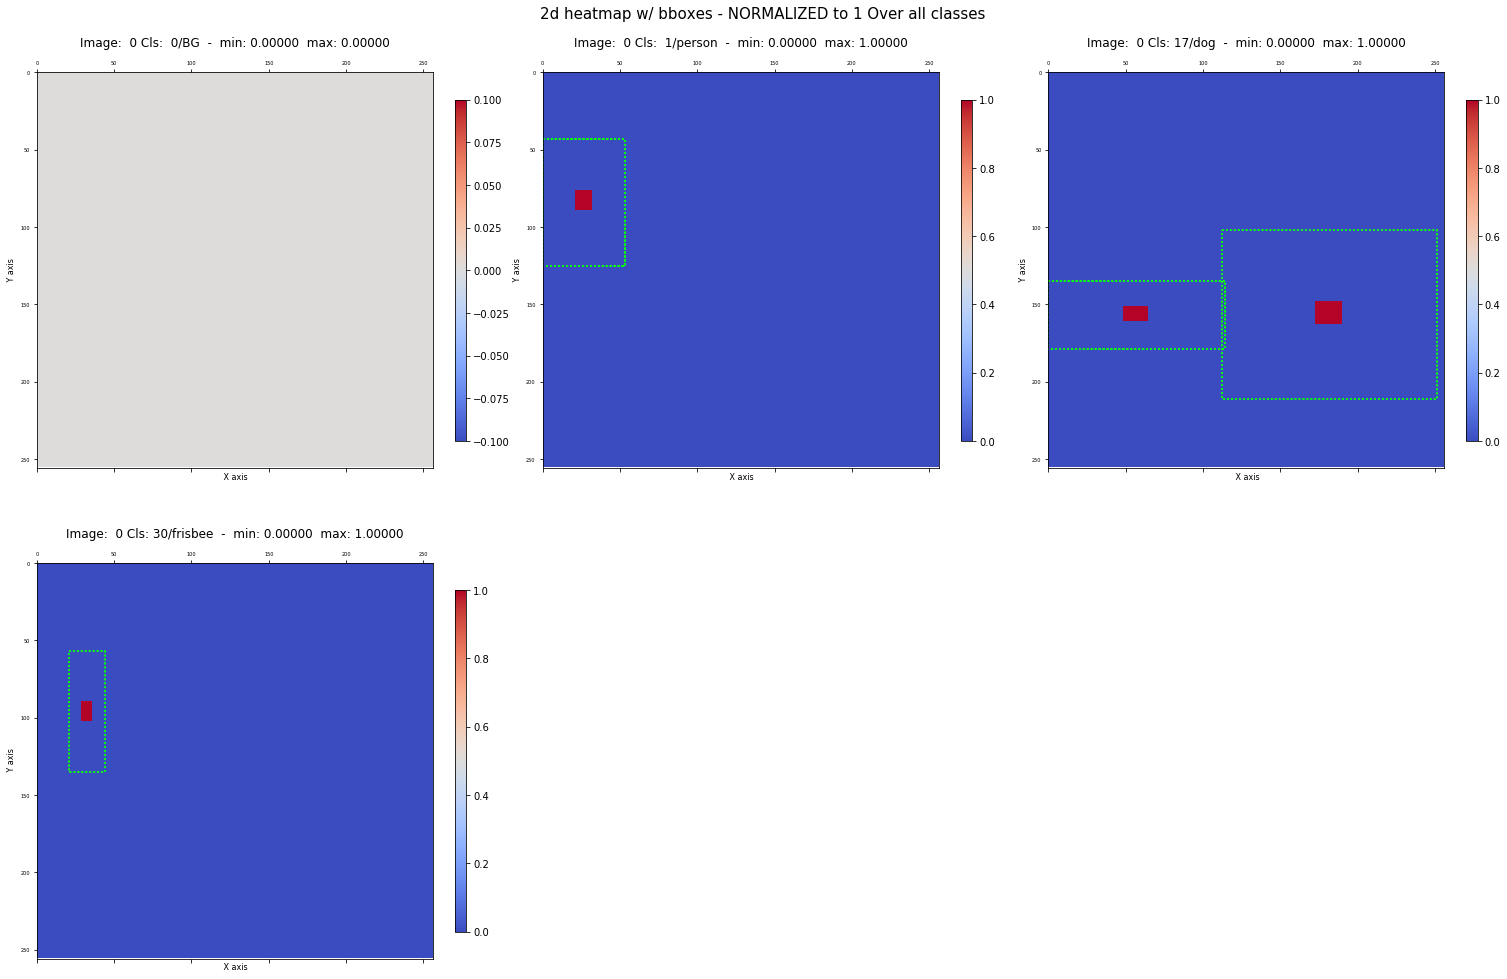

In [73]:
print('Image : {}  ClassIds: {}'.format(img_id, gt_class_ids))
plot_2d_heatmap(model_gt_heatmap, model_gt_heatmap_scores, img_id, gt_class_ids, 
                 class_names = coco_class_names, columns = 3, scale = 4, scaling = 'all')

####  2D plot of `model_fcn_heatmap` returned from model (with Ground Truth Bounding Boxes)

Image : 0  ClassIds: [0, 1, 17, 30]
 Image Id:  0  Display classes: [0, 1, 17, 30]
 rows   2  columns : 3
 min_z_all shape: ()  min_z_all: -0.08376278  max_z_all: () max_z_all: 0.9563237
 min_z_cls shape: (1, 1, 81)  max_z_cls shape: (1, 1, 81)
 SCALING == all


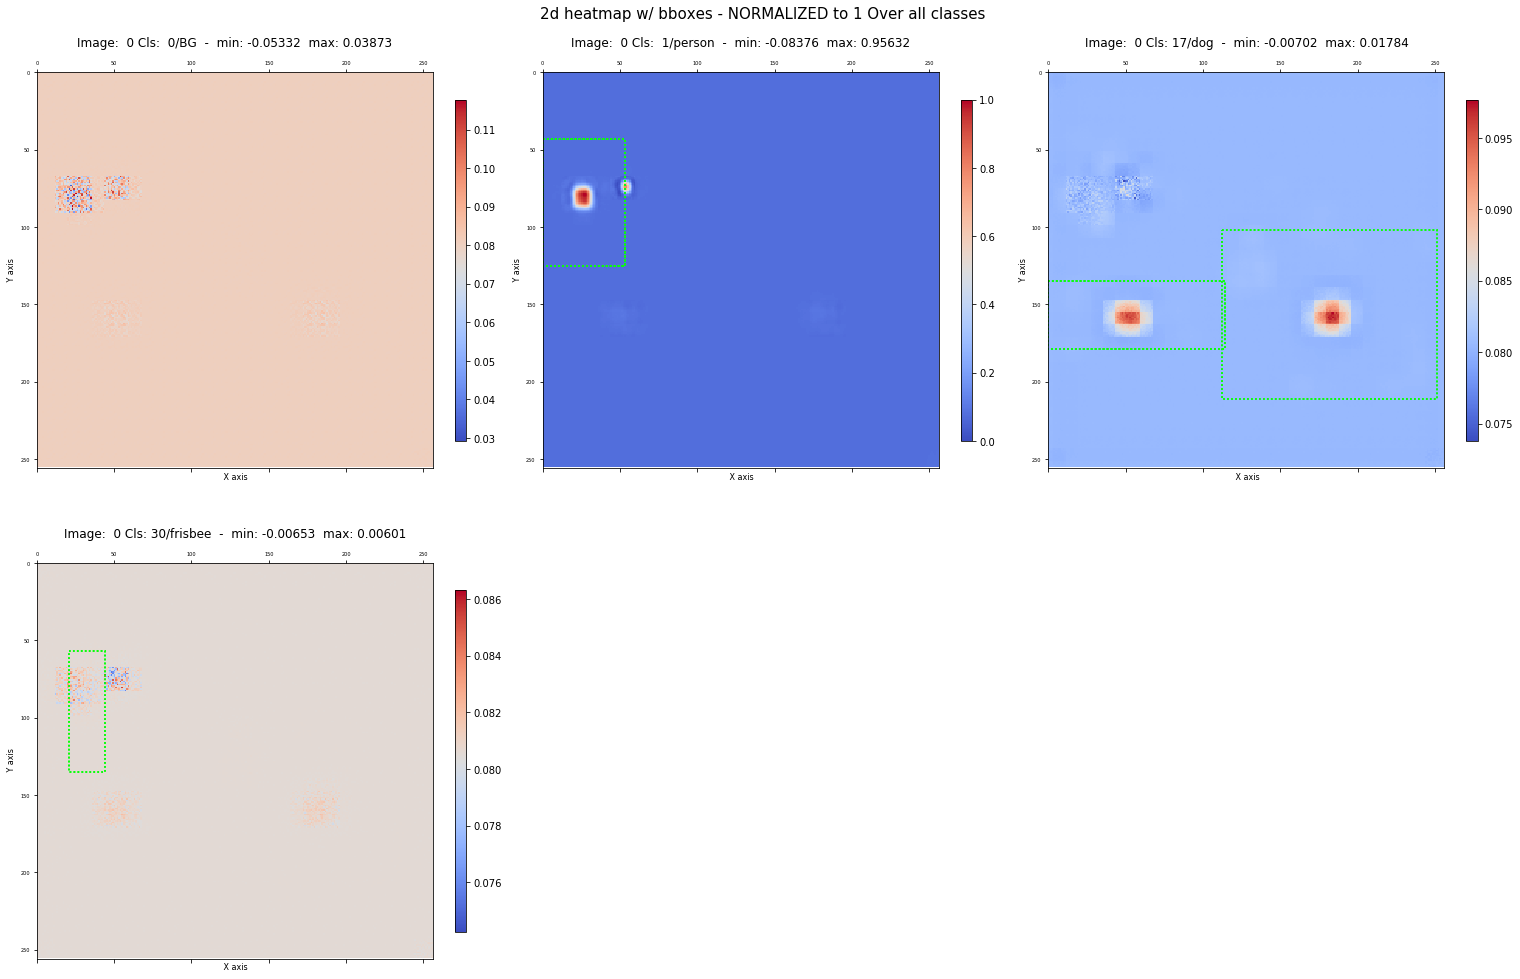

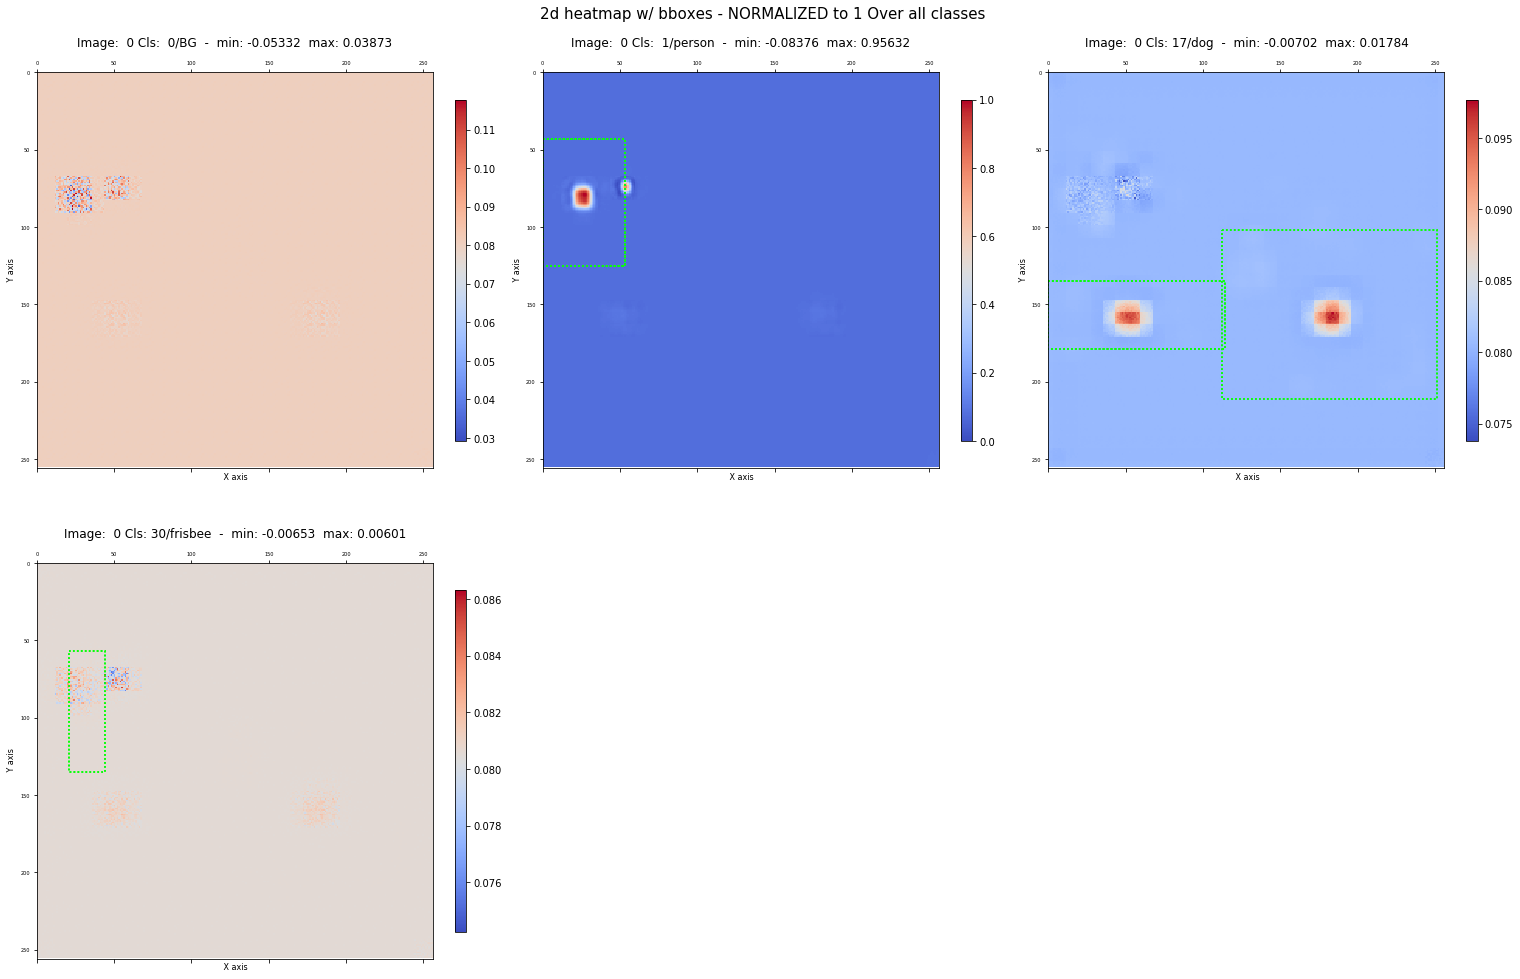

In [76]:
print('Image : {}  ClassIds: {}'.format(img_id, gt_class_ids))
plot_2d_heatmap(model_fcn_heatmap, model_gt_heatmap_scores,img_id, gt_class_ids, columns = 3,
                             class_names = coco_class_names, scale = 4, scaling = 'all')

####  2D plot of `model_fcn_heatmap` returned from model (with MRCNN PREDICTED Bounding Boxes)

(2, 256, 256, 81)
Image : 0  ClassIds: [0, 1, 17, 27, 30, 36, 37, 39]
 Image Id:  0  Display classes: [0, 1, 17, 27, 30, 36, 37, 39]
 rows   3  columns : 3
 min_z_all shape: ()  min_z_all: -0.08376278  max_z_all: () max_z_all: 0.9563237
 min_z_cls shape: (1, 1, 81)  max_z_cls shape: (1, 1, 81)
 SCALING == all


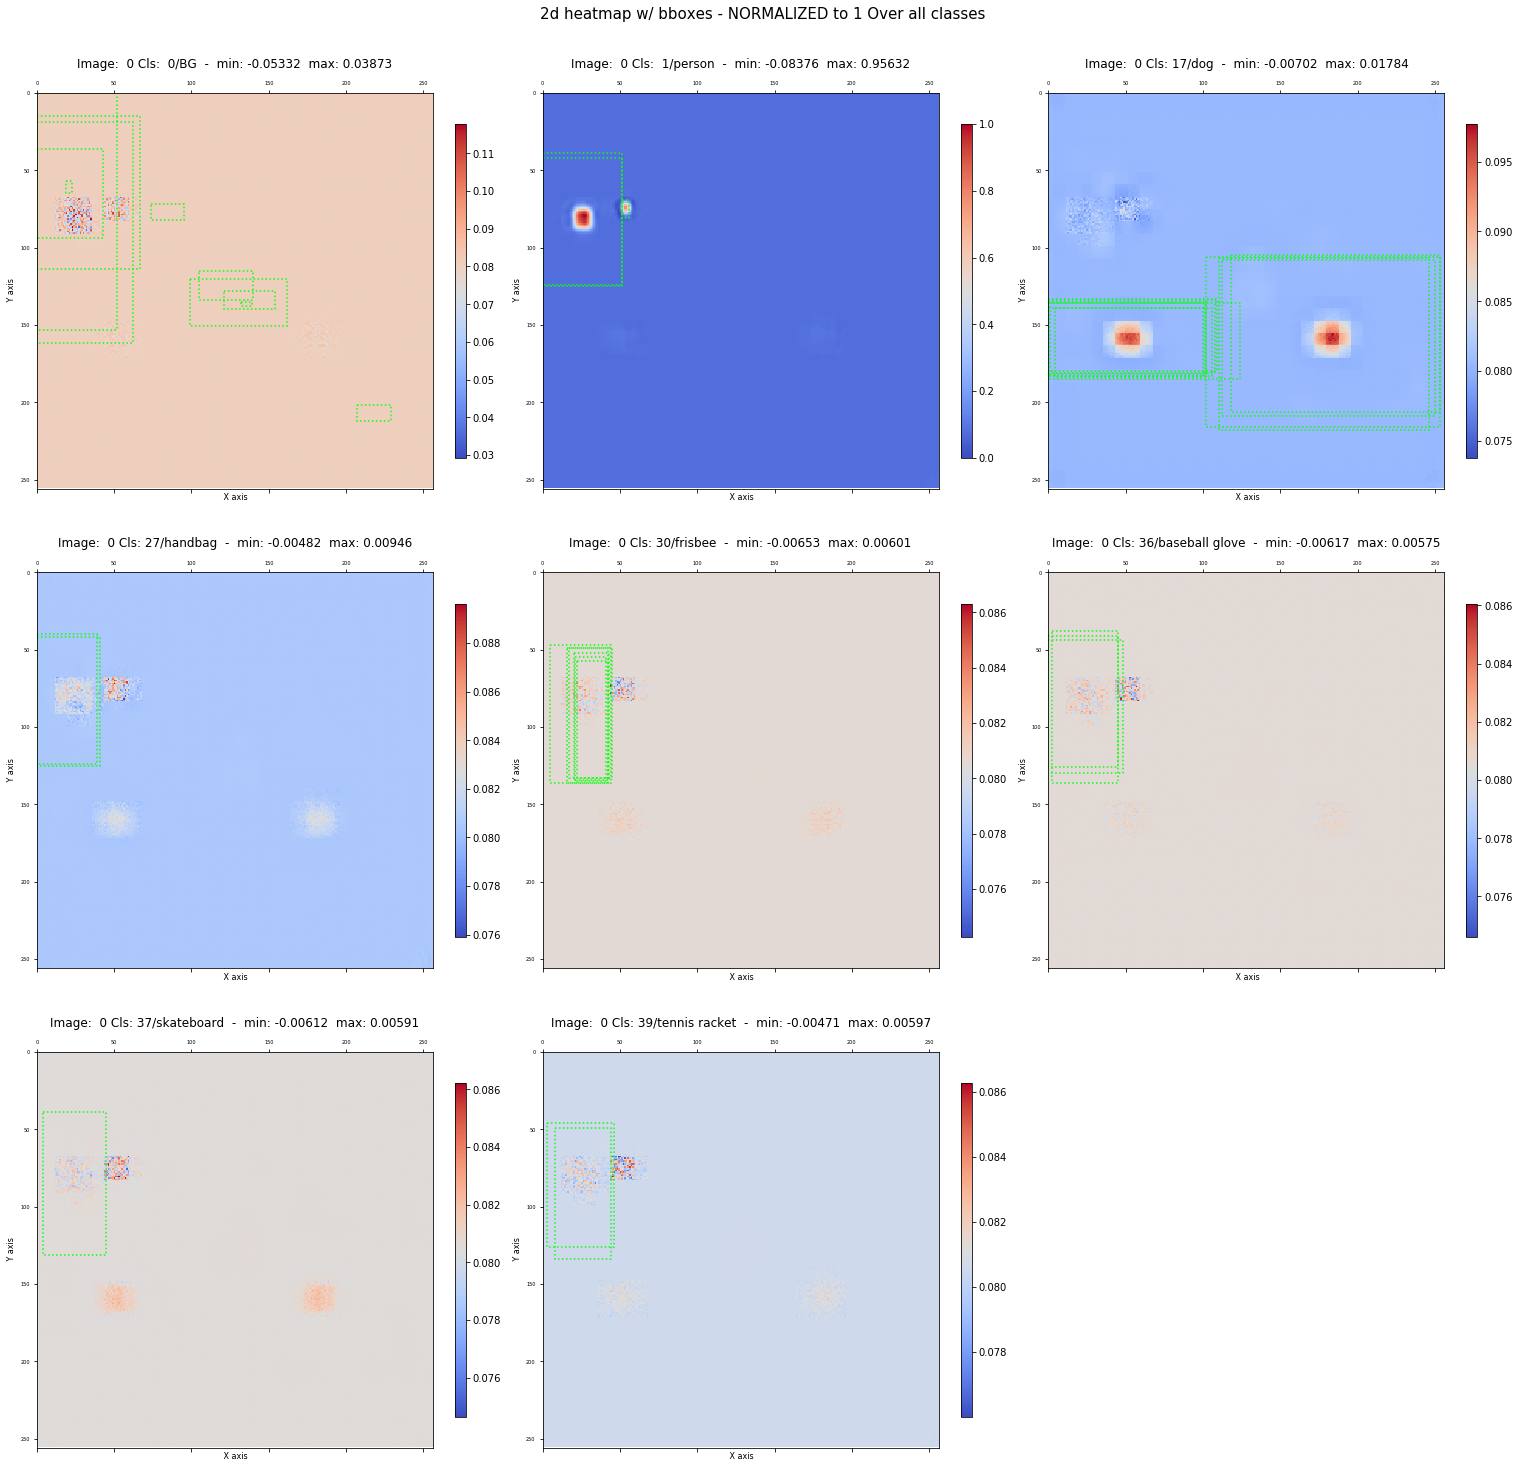

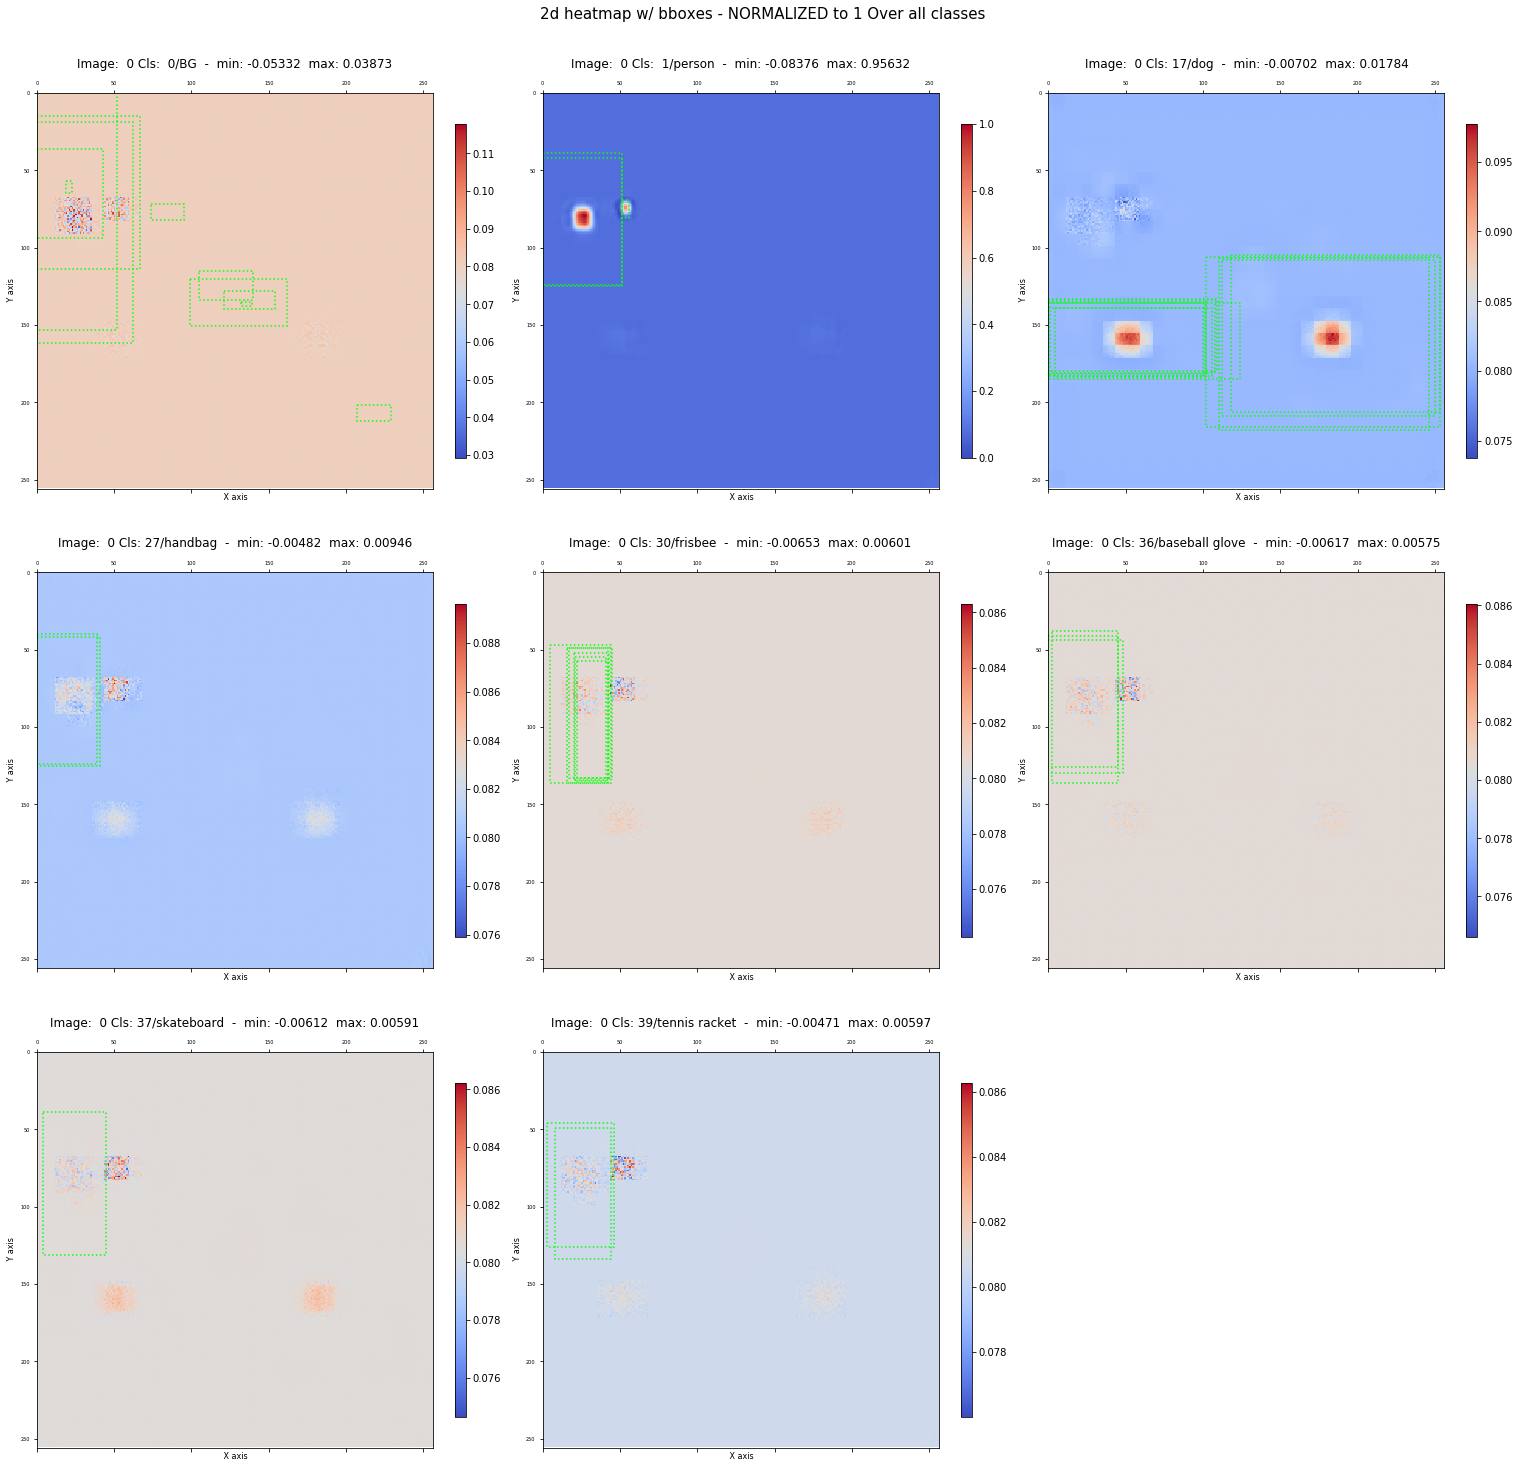

In [78]:
print(model_fcn_heatmap.shape)
print('Image : {}  ClassIds: {}'.format(img_id, pr_class_ids))
plot_2d_heatmap(model_fcn_heatmap, model_pr_heatmap_scores,img_id, pr_class_ids, columns = 3,
                             class_names = coco_class_names, scale = 4, scaling = 'all')

####  2D plot of `model_fcn_heatmap` returned from model - ALL CLASSES

In [ ]:
for img_id in [0]: ##range(mrcnn_config.BATCH_SIZE):
    class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  Pred ClassIds: {}'.format(img_id, class_ids))
    print('            Gt   ClassIds: {}'.format(np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()))
#     plot_2d_heatmap_with_bboxes(model_fcn_heatmap[...,:class_ids[-1]+1], model_gt_heatmap_scores, img_id, 
#                                 class_ids, class_names = class_names, columns = 2, scale = 4)
    fig = plot_2d_heatmap(model_fcn_heatmap, model_gt_heatmap_scores, img_id,
                                class_names = coco_class_names, columns = 4, scale = 4, scaling = True)
#     fig.savefig('fcn_heatmaps_2d.png')

####  2D plot of `pred_heatmap_norm` returned from MRCNN 

Image : 0  ClassIds: [0, 1, 17, 27, 30, 36, 37, 39]
 Image Id:  0  Display classes: [0, 1, 17, 27, 30, 36, 37, 39]
 rows   4  columns : 2
 min_z_all shape: ()  min_z_all: 0.0  max_z_all: () max_z_all: 1.0
 min_z_cls shape: (1, 1, 81)  max_z_cls shape: (1, 1, 81)
 SCALING == none 


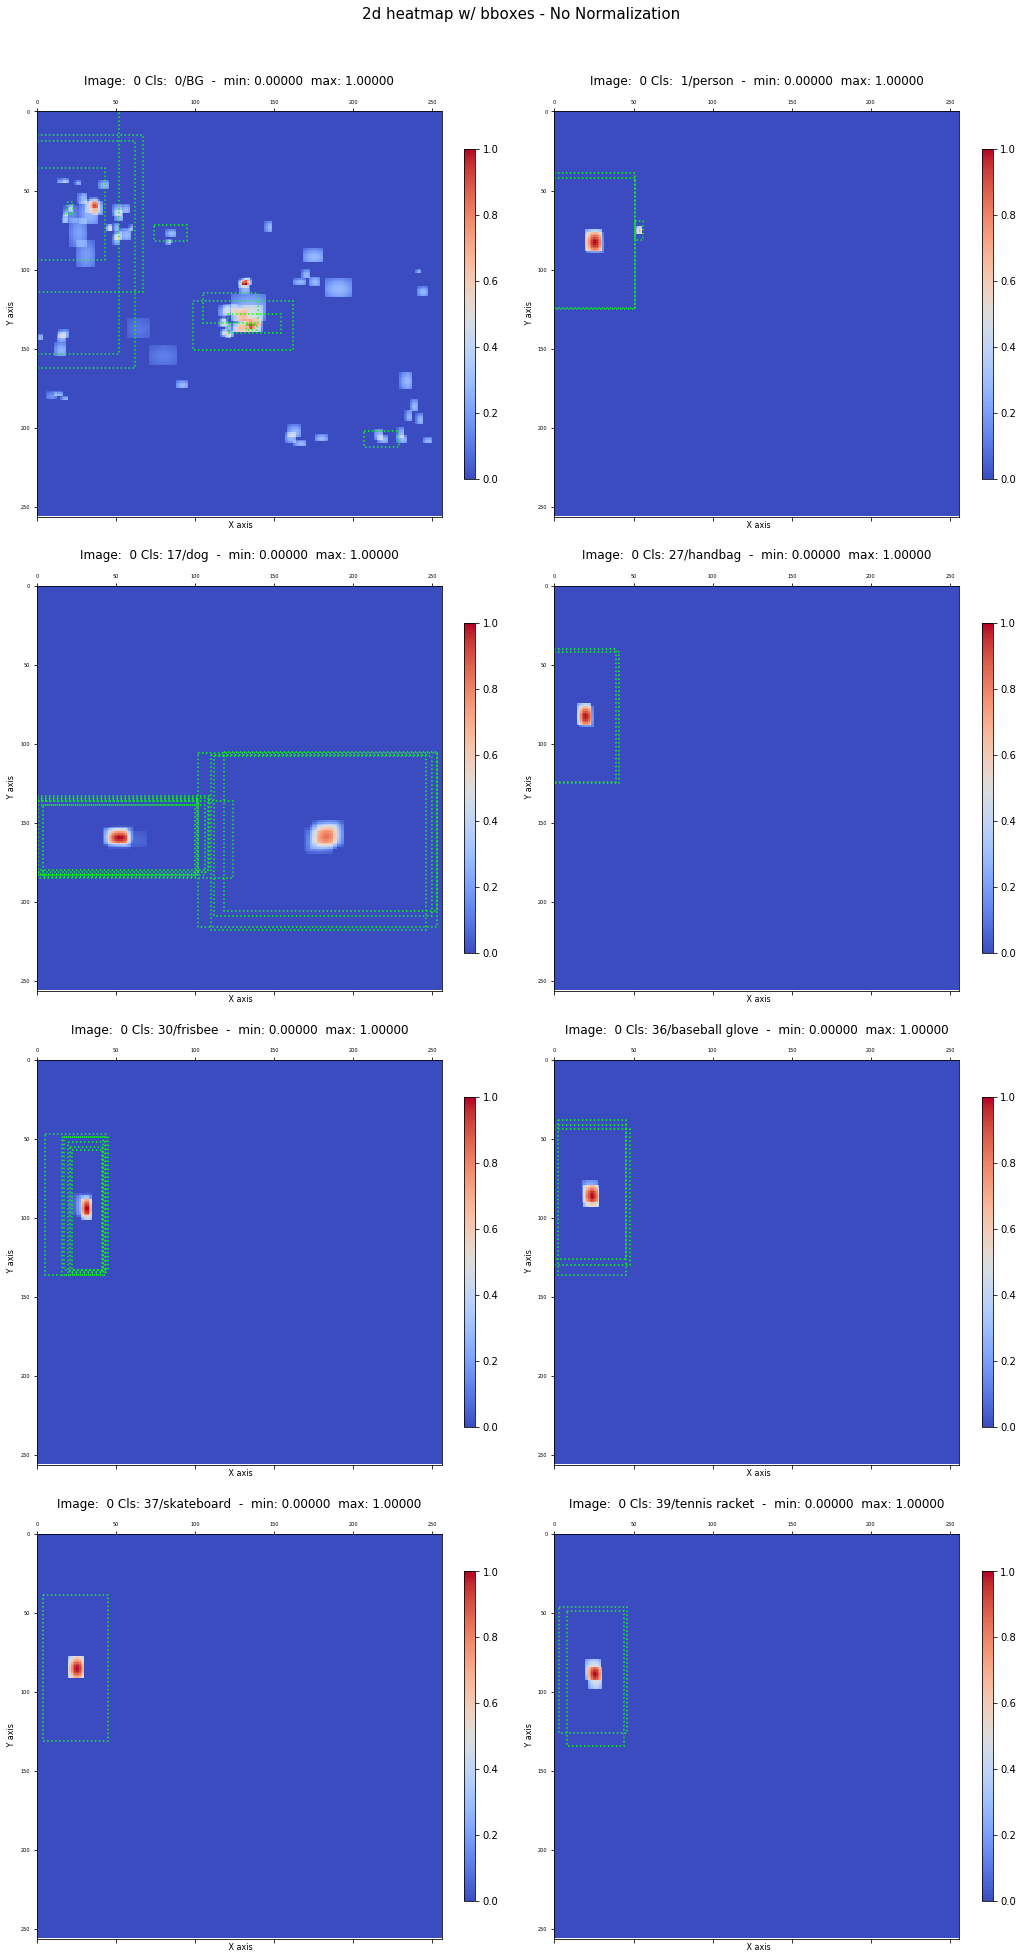

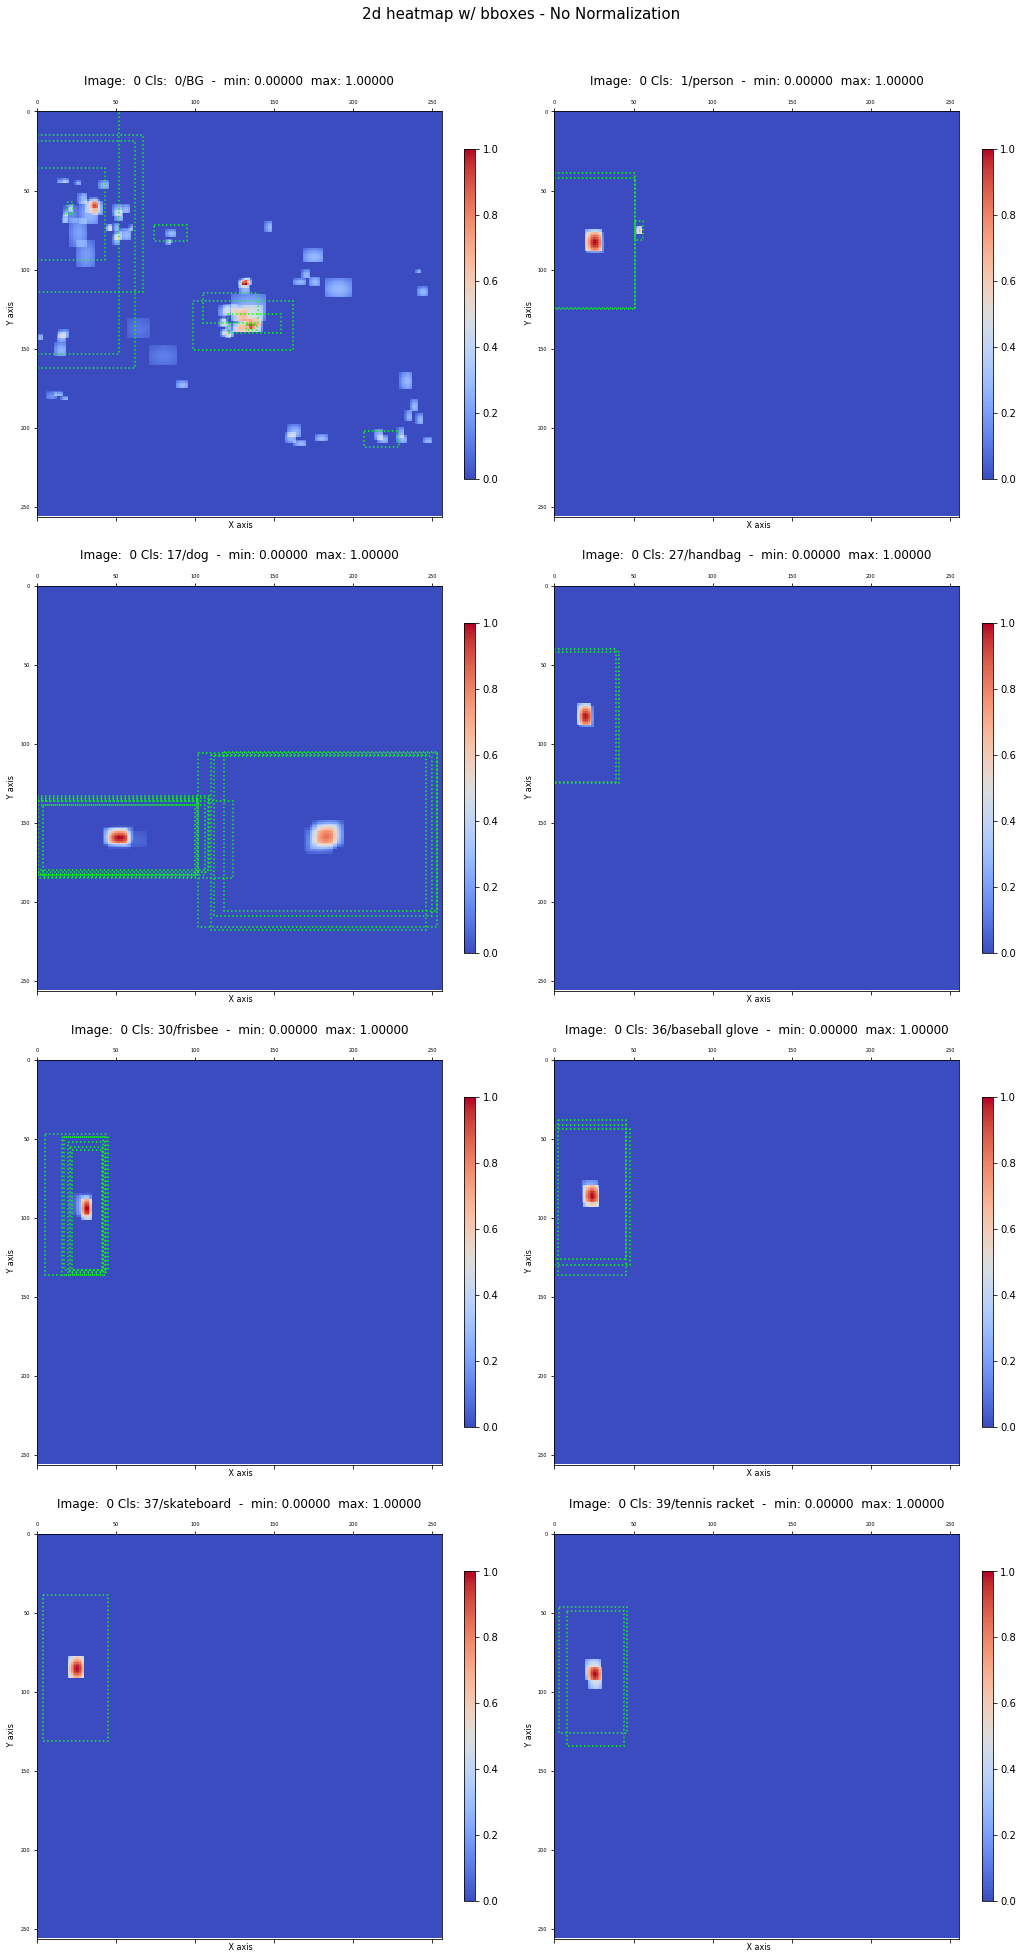

In [79]:
print('Image : {}  ClassIds: {}'.format(img_id, pr_class_ids))
plot_2d_heatmap(model_pr_heatmap, model_pr_heatmap_scores, img_id, pr_class_ids, 
                            class_names = coco_class_names, size = (7,7), scale = 4)

####  2D comparative display `pred_heatmap` / `fcn_heatmap`  

In [ ]:
for img_id in [0]: ##range(mrcnn_config.BATCH_SIZE):
    class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
#     class_ids = list(range(30))
    plot_2d_heatmap_compare(model_pred_heatmap_norm, model_fcn_heatmap, model_pred_heatmap_scores, 
                            img_id, class_ids = class_ids, class_names = coco_class_names, scale = 4, scaling = True )    

### Overlay predictions on image

#### Overlay image with gt_heatmaps

In [ ]:
from mrcnn.visualize import display_heatmaps, display_heatmaps_fcn, display_heatmaps_mrcnn
# visualize.display_image_bw(image)
print(model_gt_heatmap_scores.shape)
class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
print('class ids: ', class_ids)
display_heatmaps_mrcnn(train_batch_x, model_output, 0, hm = 'gt',
                     config = mrcnn_config, class_ids = class_ids, class_names = coco_class_names)

#### Overlay image with pred_heatmaps

In [ ]:
from mrcnn.visualize import display_heatmaps, display_heatmaps_fcn, display_heatmaps_mrcnn
# visualize.display_image_bw(image)
print(model_gt_heatmap_scores.shape)
class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
print('class ids: ', class_ids)
display_heatmaps_mrcnn(train_batch_x, model_output, 0, hm = 'pr',  
                     config = mrcnn_config, class_ids = class_ids, class_names = coco_class_names)

#### Overlay image with fcn_heatmaps

In [ ]:
for i in fcn_train_batch_x:
    print(i.shape)

In [ ]:
from mrcnn.visualize import display_heatmaps, display_heatmaps_fcn, display_heatmaps_mrcnn_fcn
# visualize.display_image_bw(image)
class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
pr_class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
print(' ground truth class ids: ' ,class_ids)
print('    predicted class ids: ' , pr_class_ids)
display_heatmaps_mrcnn_fcn(train_batch_x, fcn_train_batch_x, 0, heatmap = model_fcn_heatmap, hm = 'pr', columns = 3, 
                     config = mrcnn_config, class_ids = pr_class_ids , class_names = coco_class_names, scaling = 'class')

###  3D Plots

####  3D plot of  `gt_heatmap_norm` returned form code above

In [ ]:
for img_id in [0]: ## range(mrcnn_config.BATCH_SIZE):
    print(model_gt_heatmap.shape)
    class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_3d_heatmap(model_gt_heatmap, img_id, class_ids, class_names = coco_class_names)


####  3D plot of `pred_heatmap_norm` returned form model

In [ ]:
for img_id in [0]: ##range(mrcnn_config.BATCH_SIZE):
    print(model_pred_heatmap_norm.shape)
    class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_3d_heatmap(model_pred_heatmap_norm, img_id, class_ids, class_names = coco_class_names, zlim = 'all' )


####  3D plot of `fcn_heatmap` returned form model - classes predicted by MRCNN only 

In [ ]:
print(np.max(model_fcn_heatmap), np.min(model_fcn_heatmap))

In [ ]:
for img_id in [0]: ##range(mrcnn_config.BATCH_SIZE):
    print(model_fcn_heatmap.shape)
    class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_3d_heatmap(model_fcn_heatmap, img_id, class_ids,class_names = coco_class_names, zlim = 'one',scaling = True)


####  3D plot of `fcn_softmax` returned form model - only classes in pred_scores

In [ ]:
for img_id in [0]: ##range(mrcnn_config.BATCH_SIZE):
    print(model_fcn_heatmap.shape)
    class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_3d_heatmap(model_fcn_softmax, img_id, class_ids,class_names = coco_class_names, scaling = False)

####  3D plot of `fcn_heatmap` returned form model - all classes

In [ ]:
for img_id in [0]: ##range(mrcnn_config.BATCH_SIZE):
    class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
#     plot_3d_heatmap(model_fcn_heatmap, img_id, class_ids,class_names = class_names, size = (8,8), zlim=0)
#     plot_3d_heatmap_all_classes(model_fcn_heatmap[...,:class_ids[-1]+1], img_id, class_names = class_names, size = (8,8), zlim=0.0)
    plot_3d_heatmap(model_fcn_heatmap, img_id, class_names = class_names, columns = 2,scaling = True)

####  3D comparative display `pred_heatmap` / `fcn_heatmap` 

In [ ]:
for img_id in [0]: ##range(mrcnn_config.BATCH_SIZE):
    print(model_pred_heatmap_norm.shape)
    class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    class_ids.append(1)
    class_ids = list(range(30))
#     print(class_ids)
    plot_3d_heatmap_compare(model_pred_heatmap_norm,model_fcn_heatmap, img_id, class_ids = class_ids, 
                            class_names = class_names, size=(8,8), zlim = 'all' , scaling = True)

####  3D comparative display `gt_heatmap` / `fcn_heatmap` 

In [ ]:
for img_id in [0]: ##range(mrcnn_config.BATCH_SIZE):
    class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    class_ids.extend([1,2])
    print(class_ids)
    print(type(class_ids))
    class_ids.sort()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_3d_heatmap_compare(model_gt_heatmap,model_fcn_heatmap, img_id, class_ids, class_names = class_names, size=(8,8), zlim = 0 )

##  FCN Scoring - `FCNScoringLayer`

### Display shapes

In [21]:
print(model_gt_heatmap.shape)
print(model_gt_heatmap_scores.shape)
print(model_pr_heatmap.shape)
print(model_pr_heatmap_scores.shape)
print(model_fcn_heatmap.shape)
print(model_fcn_softmax.shape)

(2, 256, 256, 81)
(2, 81, 200, 11)
(2, 256, 256, 81)
(2, 81, 200, 11)
(2, 256, 256, 81)
(2, 256, 256, 81)


###  define batch_slice

In [ ]:
##-----------------------------------------------------------------------------------
##
##-----------------------------------------------------------------------------------

def batch_slice_fcn(inputs, graph_fn, batch_size, config = None, names=None):
    '''
    Splits inputs into slices and feeds each slice to a copy of the given
    computation graph and then combines the results. It allows you to run a
    graph on a batch of inputs even if the graph is written to support one
    instance only.

    inputs:     list of tensors. All must have the same first dimension length
    graph_fn:   A function that returns a TF tensor that's part of a graph.
    batch_size: number of slices to divide the data into.
    names:      If provided, assigns names to the resulting tensors.
    '''
    print(' batch slice fcn')
    if not isinstance(inputs, list):
        inputs = [inputs]
    fcn_hm = inputs[0]        
    pr_hm_scores = inputs[1]
    gt_hm_scores = inputs[2]
    for i,x in enumerate(inputs):
        print('input ', i ,' ----' , KB.int_shape(x), 'Keras tensor ', KB.is_keras_tensor(x))
    outputs = []
    
    for i in range(batch_size):
        inputs_slice = [x[i] for x in inputs]    # inputs is a list eg. [sc, ix] => input_slice = [sc[0], ix[0],...]
        # for i in inputs_slice:
        print(' ----' , KB.int_shape(fcn_hm[i]))
        print(' ----' , KB.int_shape(pr_hm_scores[i]))
        print(' ----' , KB.int_shape(gt_hm_scores[i]))
        
        output_slice = graph_fn(fcn_hm[i], pr_hm_scores[i], gt_hm_scores[i], config)   # pass list of inputs_slices through function => graph_fn(sc[0], ix[0],...)
    
        if not isinstance(output_slice, (tuple, list)):
            output_slice = [output_slice]
        outputs.append(output_slice)

    # Change outputs from:
    #    a list of slices where each is a list of outputs, e.g.  [ [out1[0],out2[0]], [out1[1], out2[1]],.....
    # to 
    #    a list of outputs and each has a list of slices ==>    [ [out1[0],out1[1],...] , [out2[0], out2[1],....],.....    
    
    outputs = list(zip(*outputs))

    if names is None:
        names = [None] * len(outputs)

    # for o,n in zip(outputs,names):
        # print(' outputs shape: ', len(o), 'name: ',n)
        # for i in range(len(o)):
            # print(' shape of item ',i, 'in tuple', o[i].shape)
        
    result = [tf.stack(o, axis=0, name=n) for o, n in zip(outputs, names)]
    if len(result) == 1:
        result = result[0]

    return result


##-------------------------------------------------------------------------------------------------------
##   score fcn heatmaps : gen scores from heatmap
##-------------------------------------------------------------------------------------------------------
##   We use the coordinates of the bounding boxes passed in pr_scores (or gt_scores), to calculate 
##   the score of bounding boxes overlaid on the heatmap produced by the fcn_layer
##   - convert the pr_scores (or gt_hm_scores) from a per_class/per_bbox tensor to a per_class tensor
##     [BATCH_SIZE, NUM_CLASSES, DETECTIONS_PER_CLASS, 11] --> [BATCH_SIZE, DETECTIONS_MAX_INSTANCES, 11]
##   - Extract non-zero bounding boxes
##   - calculate the Cy, Cx, and Covar of the bounding boxes 
##   - Clip the heatmap by using masks centered on Cy,Cx and +/- Covar_Y, Covar_X
##-------------------------------------------------------------------------------------------------------
def my_score_fcn_heatmaps(in_heatmap, pr_scores, gt_scores, config):

    num_detections  = tf.shape(pr_scores)[1] 
    img_h, img_w    = config.IMAGE_SHAPE[:2]
    batch_size      = config.BATCH_SIZE
    num_classes     = config.NUM_CLASSES  
    heatmap_scale   = config.HEATMAP_SCALE_FACTOR
    print('\n ')
    print('  > my_score_fcn_heatmap() for ')
    print('    in_heatmap shape : ', in_heatmap.shape)       
    print('    pr_scores  shape : ', pr_scores.shape)       
    print('    gt_scores  shape : ', gt_scores.shape)       
    
    # rois per image is determined by size of input tensor 
    #   detection mode:   config.TRAIN_ROIS_PER_IMAGE 
    #   ground_truth  :   config.DETECTION_MAX_INSTANCES
    
    rois_per_image  = KB.int_shape(pr_scores)[2] 
    # strt_cls        = 0 if rois_per_image == 32 else 1
    print('    num_detctions     : ', num_detections )
    print('    rois_per_image    : ', rois_per_image )

    ##----------------------------------------------------------------------------------------------------
    ## flatten guassian scattered and input_tensor, and pass on to build_bbox_score routine 
    ##----------------------------------------------------------------------------------------------------
    # pr_scores_shape = tf.shape(pr_scores)
    # pr_scores_flat  = tf.reshape(pr_scores, [-1, pr_scores_shape[-1]])
    # bboxes = tf.to_int32(tf.round(pr_scores_flat[...,0:4]))
    # print('    pr_scores_shape : ', pr_scores_shape.eval() )
    # print('    pr_scores_flat  : ', tf.shape(pr_scores_flat).eval())
    # print('    boxes shape     : ', tf.shape(bboxes).eval())
    # print('    Rois per image  : ', rois_per_image)
    
    ##-----------------------------------------------------------------------------    
    ## Stack non_zero bboxes from PR_SCORES into pt2_dense 
    ##-----------------------------------------------------------------------------
    # pt2_ind shape  : [?, 3] : [ {image_index, class_index , roi row_index }]
    # pt2_dense shape: [?, 11] : 
    #    pt2_dense[0:3]  roi coordinates 
    #    pt2_dense[4]    is class id 
    #    pt2_dense[5]    is score from mrcnn    
    #    pt2_dense[6]    is bbox sequence id    
    #    pt2_dense[7]    is normalized score (per class)    
    #-----------------------------------------------------------------------------
    pt2_sum = tf.reduce_sum(tf.abs(pr_scores[:,:,:4]), axis=-1)
    pt2_ind = tf.where(pt2_sum > 0)
    pt2_dense = tf.gather_nd(pr_scores, pt2_ind)
    bboxes = tf.to_int32(tf.round(pt2_dense[:,0:4]))
    hm_indices =  tf.to_int32(tf.expand_dims(pt2_dense[:,4], axis = -1))
    print('    pt2_sum shape     : ', KB.int_shape(pt2_sum))
    print('    pt2_ind shape     : ', KB.int_shape(pt2_ind))
    print('    pt2_dense shape   : ', KB.int_shape(pt2_dense))
    print('    bboxes  shape     : ', KB.int_shape(bboxes))
    print('    hm_indices shape  :',  KB.int_shape(hm_indices))
    
    ##-----------------------------------------------------------------------------
    ##  Build mean and convariance tensors for Multivariate Normal Distribution 
    ##-----------------------------------------------------------------------------
    bboxes = bboxes / heatmap_scale
    width  = bboxes[:,3] - bboxes[:,1]      # x2 - x1
    height = bboxes[:,2] - bboxes[:,0]
    cx     = bboxes[:,1] + ( width  / 2.0)
    cy     = bboxes[:,0] + ( height / 2.0)
    means  = tf.stack((cx,cy),axis = -1)
    covar  = tf.stack((width * 0.5 , height * 0.5), axis = -1)
    covar  = tf.sqrt(covar)        

    #-----------------------------------------------------------------------------------------------------
    # duplicate GAUSS_NORM <num_roi> times to pass along with bboxes to map_fn function
    #   Here we have a choice to calculate scores using the GAUSS_SUM (unnormalized) or GAUSS_NORM 
    #   (normalized). After looking at the scores and ratios for each option, I decided to go with 
    #   the normalized as the numbers are large
    #-----------------------------------------------------------------------------------------------------
    # hm_indices =  tf.cast(pt2_dense[:,4],dtype=tf.int32)

    pt2_heatmaps = tf.gather(in_heatmap, hm_indices[:,0], axis = -1)
    print('    selected heatmaps shape  :',  pt2_heatmaps.get_shape(), KB.int_shape(pt2_heatmaps))
    pt2_heatmaps = tf.transpose(pt2_heatmaps, [2,0,1])
    print('    selected heatmaps shape  :',  pt2_heatmaps.get_shape(), KB.int_shape(pt2_heatmaps))


    ##----------------------------------------------------------------------------------------------------
    ## generate score based on gaussian using bounding box masks 
    ## NOTE: Score is generated on NORMALIZED gaussian distributions (GAUSS_NORM)
    ##       If want to do this on NON-NORMALIZED, we need to apply it on GAUSS_SUM
    ##----------------------------------------------------------------------------------------------------    
    print(KB.int_shape(pt2_heatmaps),KB.int_shape(cy),KB.int_shape(cx), KB.int_shape(covar))
    scores = tf.map_fn(my_build_fcn_score, [pt2_heatmaps, cy, cx,covar], dtype=tf.float32)    
    
    ##---------------------------------------------------------------------------------------------
    ## Apply normalization per bbox scores
    ##---------------------------------------------------------------------------------------------
    print('\n    normalization ------------------------------------------------------')   
    normalizer = tf.reduce_max(scores, axis=[-1], keepdims = True)
    normalizer = tf.where(normalizer < 1.0e-15,  tf.ones_like(normalizer), normalizer)
    scores_norm = scores / normalizer
    print('    normalizer     : ', normalizer.shape) 
    print('    scores_norm    : ', scores_norm.shape)
    
    both_scores = tf.stack([scores, scores_norm], axis = -1)
    print('    both_scores    : ', both_scores.shape)
    
    # consider the two new columns for reshaping the gaussian_bbox_scores
    # new_shape   = pr_scores_shape + [0,0,0, tf.shape(scores)[-1]]        
    # bbox_scores = tf.concat([pr_scores_flat, scores], axis = -1)
    # bbox_scores = tf.reshape(bbox_scores, new_shape)
    # print('    new shape is            : ', new_shape.eval())
    # print('    pr_scores_flat          : ', tf.shape(pr_scores_flat).eval())
    # print('    Scores shape            : ', tf.shape(scores).eval())   # [(num_batches x num_class x num_rois ), 3]
    # print('    boxes_scores (rehspaed) : ', tf.shape(bbox_scores).eval())    

    #--------------------------------------------------------------------------------------------
    # this normalization moves values to [-1 +1] 
    #--------------------------------------------------------------------------------------------    
    # reduce_max = tf.reduce_max(bbox_scores[...,-1], axis = -1, keepdims=True)
    # reduce_min = tf.reduce_min(bbox_scores[...,-1], axis = -1, keepdims=True)  ## epsilon    = tf.ones_like(reduce_max) * 1e-7
    # scr_norm  = (2* (bbox_scores[...,-1] - reduce_min) / (reduce_max - reduce_min)) - 1     

    # scr_norm     = tf.expand_dims(scr_norm, axis = -1)                             # shape (num_imgs, num_class, 32, 1)
    # fcn_scores   = KB.identity(tf.concat([bbox_scores, scr_norm, scr_L2norm], axis = -1), name = 'fcn_heatmap_scores') 
    ##--------------------------------------------------------------------------------------------
    ## Add returned values from scoring to the end of the input score 
    ##--------------------------------------------------------------------------------------------    
    fcn_scores  = tf.concat([pt2_dense, both_scores], axis = -1, name='fcn_heatmap_scores')
    Padding    = tf.maximum(num_detections- tf.shape(fcn_scores)[0], 0)
    fcn_padded_scores = tf.pad(fcn_scores, [(0, Padding), (0, 0)])

    print('    both_scores        : ', both_scores.shape ,' Keras tensor ', KB.is_keras_tensor(both_scores) )  
    print('    fcn_scores         : ', fcn_scores.shape ,' Keras tensor ', KB.is_keras_tensor(fcn_scores) )  
    print('    padding            : ', Padding.shape ,' Keras tensor ', KB.is_keras_tensor(Padding) )  
    print('    fcn_padded_scores  : ', fcn_padded_scores.shape ,' Keras tensor ', KB.is_keras_tensor(fcn_padded_scores) )  
    print('    complete')        

    return fcn_padded_scores   

##--------------------------------------------------------------------------------------------------------
##
##--------------------------------------------------------------------------------------------------------        
def my_build_fcn_score(input_list):
    '''
    Inputs:
    -----------
        heatmap_tensor :    [ image height, image width ]
        input_row      :    [y1, x1, y2, x2] in absolute (non-normalized) scale

    Returns
    -----------
        gaussian_sum :      sum of gaussian heatmap vlaues over the area covered by the bounding box
        bbox_area    :      bounding box area (in pixels)
    '''
    print('    build_fcn_score()')
    heatmap_tensor, cy, cx, covar = input_list
    with tf.variable_scope('mask_routine'):
        start_y      = tf.maximum(cy-covar[1],0)
        end_y        = tf.minimum(cy+covar[1], KB.int_shape(heatmap_tensor)[0])
        start_x      = tf.maximum(cx-covar[0],0)
        end_x        = tf.minimum(cx+covar[0], KB.int_shape(heatmap_tensor)[1])
        y_extent     = tf.range(start_y, end_y)
        x_extent     = tf.range(start_x, end_x)
        Y,X          = tf.meshgrid(y_extent, x_extent)
        mask_indices = tf.stack([Y,X],axis=2)        
        mask_indices = tf.reshape(mask_indices,[-1,2])
        mask_indices = tf.to_int32(mask_indices)
        mask_size    = tf.shape(mask_indices)[0]
        mask_updates = tf.ones([mask_size], dtype = tf.float32)    
        mask         = tf.scatter_nd(mask_indices, mask_updates, tf.shape(heatmap_tensor))

        heatmap_tensor = tf.multiply(heatmap_tensor, mask, name = 'mask_applied')
        score        = tf.reduce_sum(heatmap_tensor)
        print(' heatmapshape:', heatmap_tensor.get_shape())
    return score        

In [ ]:
##--------------------------------------------------------------------------
## setup input values
pr_hm_scores  = tf.identity(model_pr_heatmap_scores)
gt_hm_scores  = tf.identity(model_gt_heatmap_scores)
fcn_heatmap   = tf.identity(model_fcn_heatmap)
# in_tensor = tf.placeholder(tf.float32, shape=[3,4,32,6], name = 'in_tensor')

config = fcn_model.config
self   = fcn_model
names = ['Dev']
##--------------------------------------------------------------------------


# print('   > FCNScoreLayer Call() ', len(inputs))
print('     fcn_heatmap.shape    :', fcn_heatmap.shape , KB.int_shape(fcn_heatmap), 'Keras tensor ', KB.is_keras_tensor(fcn_heatmap))
# fcn_heatmap = KB.permute_dimensions(fcn_heatmap, (0,3,1,2))
print('     fcn_heatmap.shape    :', fcn_heatmap.shape , KB.int_shape(fcn_heatmap), 'Keras tensor ', KB.is_keras_tensor(fcn_heatmap))
print('     pr_hm_scores.shape   :', pr_hm_scores.shape, KB.int_shape(pr_hm_scores), 'Keras tensor ', KB.is_keras_tensor(pr_hm_scores))
print('     gt_hm_scores.shape   :', gt_hm_scores.shape, KB.int_shape(gt_hm_scores), 'Keras tensor ', KB.is_keras_tensor(gt_hm_scores))

fcn_scores  = batch_slice_fcn([fcn_heatmap, pr_hm_scores, gt_hm_scores], my_score_fcn_heatmaps, 
                                    self.config.IMAGES_PER_GPU, self.config)

# fcn_scores  = self.score_fcn_heatmaps(fcn_heatmap, pr_hm_scores, gt_hm_scores, self.config)

print('\n    Output build_fcn_score ')
print('     fcn_scores  : ', fcn_scores.shape  , 'Keras tensor ', KB.is_keras_tensor(fcn_scores))
print('     complete')

### `score_fcn_heatmaps()`

In [ ]:
def score_fcn_heatmaps(self, in_heatmap, pr_scores, gt_hm_scores, names = None):

    num_detections  = tf.shape(pr_scores)[1] 
    img_h, img_w    = self.config.IMAGE_SHAPE[:2]
    batch_size      = self.config.BATCH_SIZE
    num_classes     = self.config.NUM_CLASSES  
    heatmap_scale   = self.config.HEATMAP_SCALE_FACTOR
    print('\n ')
    print('  > NEW build_heatmap() for ', names )
    print('    orignal in_heatmap shape : ', in_heatmap.shape)       
    # rois per image is determined by size of input tensor 
    #   detection mode:   config.TRAIN_ROIS_PER_IMAGE 
    #   ground_truth  :   config.DETECTION_MAX_INSTANCES

    rois_per_image  = KB.int_shape(pr_scores)[2] 
    # strt_cls        = 0 if rois_per_image == 32 else 1
    print('    num_detctions     : ', num_detctions )
    print('    rois_per_image    : ', rois_per_image )

    ##----------------------------------------------------------------------------------------------------
    ## flatten guassian scattered and input_tensor, and pass on to build_bbox_score routine 
    ##----------------------------------------------------------------------------------------------------
    # pr_scores_shape = tf.shape(pr_scores)
    # pr_scores_flat  = tf.reshape(pr_scores, [-1, pr_scores_shape[-1]])
    # bboxes = tf.to_int32(tf.round(pr_scores_flat[...,0:4]))
    # print('    pr_scores_shape : ', pr_scores_shape.eval() )
    # print('    pr_scores_flat  : ', tf.shape(pr_scores_flat).eval())
    # print('    boxes shape     : ', tf.shape(bboxes).eval())
    # print('    Rois per image  : ', rois_per_image)

    ##-----------------------------------------------------------------------------    
    ## Stack non_zero bboxes from PR_SCORES into pt2_dense 
    ##-----------------------------------------------------------------------------
    # pt2_ind shape  : [?, 3] : [ {image_index, class_index , roi row_index }]
    # pt2_dense shape: [?, 11] : 
    #    pt2_dense[0:3]  roi coordinates 
    #    pt2_dense[4]    is class id 
    #    pt2_dense[5]    is score from mrcnn    
    #    pt2_dense[6]    is bbox sequence id    
    #    pt2_dense[7]    is normalized score (per class)    
    #-----------------------------------------------------------------------------
    pt2_sum = tf.reduce_sum(tf.abs(pr_scores[:,:,:,:4]), axis=-1)
    pt2_ind = tf.where(pt2_sum > 0)
    pt2_dense = tf.gather_nd(pr_scores, pt2_ind)
    bboxes = tf.to_int32(tf.round(pt2_dense[...,0:4]))
    print('    pt2_sum shape  : ', KB.int_shape(pt2_sum.shape))
    print('    pt2_ind shape  : ', KB.int_shape(pt2_ind.shape))
    print('    pt2_dense shape: ', KB.int_shape(pt2_dense))
    print('    bboxes  shape  : ', KB.int_shape(bboxes))

    ##-----------------------------------------------------------------------------
    ##  Build mean and convariance tensors for Multivariate Normal Distribution 
    ##-----------------------------------------------------------------------------
    bboxes = bboxes / heatmap_scale
    width  = boxes[:,3] - boxes[:,1]      # x2 - x1
    height = boxes[:,2] - boxes[:,0]
    cx     = boxes[:,1] + ( width  / 2.0)
    cy     = boxes[:,0] + ( height / 2.0)
    means  = tf.stack((cx,cy),axis = -1)
    covar  = tf.stack((width * 0.5 , height * 0.5), axis = -1)
    covar  = tf.sqrt(covar)        

    #-----------------------------------------------------------------------------------------------------
    # duplicate GAUSS_NORM <num_roi> times to pass along with bboxes to map_fn function
    #   Here we have a choice to calculate scores using the GAUSS_SUM (unnormalized) or GAUSS_NORM 
    #   (normalized). After looking at the scores and ratios for each option, I decided to go with 
    #   the normalized as the numbers are large
    #-----------------------------------------------------------------------------------------------------
    hm_indices =  tf.cast(pt2_dense[:,4],dtype=tf.int32)
    print('    hm_indices shape         :',  hm_indices.get_shape(), KB.int_shape(hm_indices))
    pt2_heatmaps = tf.gather(in_heatmap, hm_indices, axis = -1)
    print('    selected heatmaps shape  :',  pt2_heatmaps.get_shape(), KB.int_shape(pt2_heatmaps))
    pt2_heatmaps = tf.transpose(in_heatmap, [2,0,1])
    print('    selected heatmaps shape  :',  pt2_heatmaps.get_shape(), KB.int_shape(pt2_heatmaps))


    ##----------------------------------------------------------------------------------------------------
    ## generate score based on gaussian using bounding box masks 
    ## NOTE: Score is generated on NORMALIZED gaussian distributions (GAUSS_NORM)
    ##       If want to do this on NON-NORMALIZED, we need to apply it on GAUSS_SUM
    ##----------------------------------------------------------------------------------------------------    
    print(KB.int_shape(pt2_heatmaps),KB.int_shape(cy),KB.int_shape(cx), KB.int_shape(covar))
    scores = tf.map_fn(build_fcn_score, [pt2_heatmaps, cy, cx,covar], dtype=tf.float32)    

    ##---------------------------------------------------------------------------------------------
    ## Apply normalization per bbox scores
    ##---------------------------------------------------------------------------------------------
    print('\n    normalization ------------------------------------------------------')   
    normalizer = tf.reduce_max(scores, axis=[-1], keepdims = True)
    normalizer = tf.where(normalizer < 1.0e-15,  tf.ones_like(normalizer), normalizer)
    scores_norm = scores / normalizer
    print('    normalizer     : ', normalizer.shape) 
    print('    scores_norm    : ', scores_norm.shape)

    both_scores = tf.stack([scores, scores_norm], axis = -1)
    print('    both_scores    : ', both_scores.shape)

    # consider the two new columns for reshaping the gaussian_bbox_scores
    # new_shape   = pr_scores_shape + [0,0,0, tf.shape(scores)[-1]]        
    # bbox_scores = tf.concat([pr_scores_flat, scores], axis = -1)
    # bbox_scores = tf.reshape(bbox_scores, new_shape)
    # print('    new shape is            : ', new_shape.eval())
    # print('    pr_scores_flat          : ', tf.shape(pr_scores_flat).eval())
    # print('    Scores shape            : ', tf.shape(scores).eval())   # [(num_batches x num_class x num_rois ), 3]
    # print('    boxes_scores (rehspaed) : ', tf.shape(bbox_scores).eval())    

    #--------------------------------------------------------------------------------------------
    # this normalization moves values to [-1 +1] 
    #--------------------------------------------------------------------------------------------    
    # reduce_max = tf.reduce_max(bbox_scores[...,-1], axis = -1, keepdims=True)
    # reduce_min = tf.reduce_min(bbox_scores[...,-1], axis = -1, keepdims=True)  ## epsilon    = tf.ones_like(reduce_max) * 1e-7
    # scr_norm  = (2* (bbox_scores[...,-1] - reduce_min) / (reduce_max - reduce_min)) - 1     

    # scr_norm     = tf.expand_dims(scr_norm, axis = -1)                             # shape (num_imgs, num_class, 32, 1)
    # fcn_scores   = KB.identity(tf.concat([bbox_scores, scr_norm, scr_L2norm], axis = -1), name = 'fcn_heatmap_scores') 
    ##--------------------------------------------------------------------------------------------
    ## Add returned values from scoring to the end of the input score 
    ##--------------------------------------------------------------------------------------------    
    fcn_scores  = tf.concat([pt2_dense, both_scores], axis = -1, name='fcn_heatmap_scores')
    print('    fcn_scores     : ', fcn_scores.shape)
    print('    fcn_scores  final shape : ', fcn_scores.shape ,' Keras tensor ', KB.is_keras_tensor(fcn_scores) )  
    print('    complete')

    return fcn_scores     
        


###  `build_fcn_score`

In [56]:
def build_fcn_score(input_list):
    '''
    Inputs:
    -----------
        heatmap_tensor :    [ image height, image width ]
        input_row      :    [y1, x1, y2, x2] in absolute (non-normalized) scale

    Returns
    -----------
        gaussian_sum :      sum of gaussian heatmap vlaues over the area covered by the bounding box
        bbox_area    :      bounding box area (in pixels)
    '''
#     heatmap_tensor, input_row = input_list
    heatmap_tensor, cy, cx, covar = input_list
    with tf.variable_scope('mask_routine'):
        start_y      = tf.maximum(cy-covar[1],0)
        end_y        = tf.minimum(cy+covar[1], KB.int_shape(heatmap_tensor)[0])
        start_x      = tf.maximum(cx-covar[0],0)
        end_x        = tf.minimum(cx+covar[0], KB.int_shape(heatmap_tensor)[1])
        y_extent     = tf.range(start_y, end_y)
        x_extent     = tf.range(start_x, end_x)
        Y,X          = tf.meshgrid(y_extent, x_extent)
        mask_indices = tf.stack([Y,X],axis=2)        
        mask_indices = tf.reshape(mask_indices,[-1,2])
        mask_indices = tf.to_int32(mask_indices)
        mask_size    = tf.shape(mask_indices)[0]
        mask_updates = tf.ones([mask_size], dtype = tf.float32)    
        mask         = tf.scatter_nd(mask_indices, mask_updates, tf.shape(heatmap_tensor))
        # mask_sum    =  tf.reduce_sum(mask)
        heatmap_tensor = tf.multiply(heatmap_tensor, mask, name = 'mask_applied')
        score        = tf.reduce_sum(heatmap_tensor)
        print(' heatmapshape:', heatmap_tensor.get_shape())
    return score



def normalize(x, low = 0.0, high = 1.0):
    #--------------------------------------------------------------------------------------------
    # this normalization moves values to [0, +1] 
    #--------------------------------------------------------------------------------------------    
    reduce_max = tf.reduce_max(x, axis = -2, keepdims=True)
    reduce_min = tf.reduce_min(x, axis = -2, keepdims=True)  ## epsilon    = tf.ones_like(reduce_max) * 1e-7
    reduce_max = tf.where(reduce_max  < +1.0e-15,  tf.ones_like(reduce_max) * high, reduce_max)
    reduce_min = tf.where(reduce_min  > -1.0e-15,  tf.ones_like(reduce_min) * low,  reduce_min)

#     y  = tf.divide( (x- reduce_min) , (reduce_max - reduce_min), name='fcn_heatmap_norm')
    y  = (x- reduce_min) / (reduce_max - reduce_min)
    y  = y * (high - low) + low 
    
    print()
    print(' normalize() ------------------------------------------------------') 
    print('    input shape      : ', KB.int_shape(x))
    print('    reduce_min shape : ', KB.int_shape(reduce_min))
    print('    reduce_max shape : ', KB.int_shape(reduce_max))
    print('        output shape : ', KB.int_shape(y))

    return y



### Develop `score_fcn_heatmaps()`

In [57]:
##--------------------------------------------------------------------------
## setup input values
pr_scores  = tf.identity(model_pr_heatmap_scores)
gt_scores  = tf.identity(model_gt_heatmap_scores)
in_heatmap = tf.identity(model_fcn_heatmap)

# in_tensor = tf.placeholder(tf.float32, shape=[3,4,32,6], name = 'in_tensor')

config = fcn_model.config
self   = fcn_model
names = ['Dev']
##--------------------------------------------------------------------------

In [60]:
# sess = KB.get_session()
# with sess.as_default():
##----------------------------------------------------------------------------------------------------------------------          
##   build_fcn_scores 
##----------------------------------------------------------------------------------------------------------------------          
# def build_fcn_scores(self, in_heatmap, pr_scores, gt_hm_scores, names = None):

detections_per_image  = pr_scores.shape[2] 
rois_per_image  = KB.int_shape(pr_scores)[2] 
img_h, img_w    = self.config.IMAGE_SHAPE[:2]
batch_size      = self.config.BATCH_SIZE
num_classes     = self.config.NUM_CLASSES  
heatmap_scale   = self.config.HEATMAP_SCALE_FACTOR
print('\n ')
print('  > NEW build_heatmap() for ', names )
print('    orignal in_heatmap shape : ', in_heatmap.shape)       
# rois per image is determined by size of input tensor 
#   detection mode:   config.TRAIN_ROIS_PER_IMAGE 
#   ground_truth  :   config.DETECTION_MAX_INSTANCES

print('    detctions_per_image : ', detections_per_image, 'pr_scores shape', pr_scores.shape )
print('    rois_per_image      : ', rois_per_image )
print('    config.DETECTION_MAX_INSTANCES   : ', self.config.DETECTION_MAX_INSTANCES)
print('    config.DETECTIONS_PER_CLASS    : ', self.config.DETECTION_PER_CLASS)

##----------------------------------------------------------------------------------------------------
## flatten guassian scattered and input_tensor, and pass on to build_bbox_score routine 
# generate score based on gaussian using bounding box masks 
# NOTE: Score is generated on NORMALIZED gaussian distributions (GAUSS_NORM)
#       If want to do this on NON-NORMALIZED, we need to apply it on GAUSS_SUM
##----------------------------------------------------------------------------------------------------

#     pr_scores_shape = tf.shape(pr_scores)
#     pr_scores_flat  = tf.reshape(pr_scores, [-1, pr_scores_shape[-1]])
#     bboxes = tf.to_int32(tf.round(pr_scores_flat[...,0:4]))
#     print('    pr_scores_shape  : ', pr_scores_shape.eval() )
#     print('    pr_scores_flat   : ', tf.shape(pr_scores_flat).eval())
#     print('    boxes shape      : ', tf.shape(bboxes).eval())
#     print('    Rois per image   : ', rois_per_image)

##-----------------------------------------------------------------------------    
## Stack non_zero bboxes from PR_SCORES into pt2_dense 
##-----------------------------------------------------------------------------
# pt2_ind shape  : [?, 3] : [ {image_index, class_index , roi row_index }]
# pt2_dense shape: [?, 11] : 
#    pt2_dense[0:3]  roi coordinates 
#    pt2_dense[4]    is class id 
#    pt2_dense[5]    is score from mrcnn    
#    pt2_dense[6]    is bbox sequence id    
#    pt2_dense[7]    is normalized score (per class)    
#-----------------------------------------------------------------------------
pt2_sum = tf.reduce_sum(tf.abs(pr_scores[:,:,:,:4]), axis=-1)
pt2_ind = tf.where(pt2_sum > 0)
pt2_dense = tf.gather_nd(pr_scores, pt2_ind)
bboxes = tf.to_int32(tf.round(pt2_dense[...,0:4]))
print('    in_heatmap          : ', in_heatmap.shape)
print('    pr_scores.shape     : ', pr_scores.shape)
print('    pt2_sum shape       : ', pt2_sum.shape, KB.int_shape(pt2_sum))
print('    pt2_ind shape       : ', pt2_ind.shape, KB.int_shape(pt2_ind))     
#     print(pt2_ind.eval())
print('    pt2_dense shape     : ', pt2_dense.get_shape(), KB.int_shape(pt2_dense))
print('    bboxes  shape       : ', KB.int_shape(bboxes))
#     print('    pt2_dense        : ', pt2_dense.eval())   


##-----------------------------------------------------------------------------
##  Build mean and convariance tensors for Multivariate Normal Distribution 
##-----------------------------------------------------------------------------
bboxes = bboxes / heatmap_scale
width  = bboxes[:,3] - bboxes[:,1]      # x2 - x1
height = bboxes[:,2] - bboxes[:,0]
cx     = bboxes[:,1] + ( width  / 2.0)
cy     = bboxes[:,0] + ( height / 2.0)
means  = tf.stack((cx,cy),axis = -1)
covar  = tf.stack((width * 0.5 , height * 0.5), axis = -1)
covar  = tf.sqrt(covar)            


#-----------------------------------------------------------------------------------------------------
# duplicate GAUSS_NORM <num_roi> times to pass along with bboxes to map_fn function
#   Here we have a choice to calculate scores using the GAUSS_SUM (unnormalized) or GAUSS_NORM 
#   (normalized). After looking at the scores and ratios for each option, I decided to go with 
#   the normalized as the numbers are large
#-----------------------------------------------------------------------------------------------------
hm_indices =  tf.cast(pt2_dense[:,4],dtype=tf.int32)
hm_indices2 = tf.cast(pt2_ind[:, :2],dtype=tf.int32)
print('    hm_indices shape         :',  hm_indices.get_shape(), KB.int_shape(hm_indices))
pt2_heatmaps = tf.transpose(in_heatmap, [0,3,1,2])
print('    selected heatmaps shape  :',  pt2_heatmaps.get_shape(), KB.int_shape(pt2_heatmaps))
pt2_heatmaps = tf.gather_nd(pt2_heatmaps, hm_indices2 )
print('    selected heatmaps shape  :',  pt2_heatmaps.get_shape(), KB.int_shape(pt2_heatmaps))


# pt2_heatmaps = tf.transpose(pt2_heatmaps, [2,0,1])
# pt2_heatmaps = tf.transpose(pt2_heatmaps, [0,3,1,2])
# print('    selected heatmaps shape  :',  pt2_heatmaps.get_shape(), KB.int_shape(pt2_heatmaps))
# pt2_hm_reshape = tf.reshape(pt2_heatmaps,[-1, pt2_heatmaps.shape[2], pt2_heatmaps.shape[3]])


 
  > NEW build_heatmap() for  ['Dev']
    orignal in_heatmap shape :  (2, 256, 256, 81)
    detctions_per_image :  200 pr_scores shape (2, 81, 200, 11)
    rois_per_image      :  200
    config.DETECTION_MAX_INSTANCES   :  100
    config.DETECTIONS_PER_CLASS    :  200
    in_heatmap          :  (2, 256, 256, 81)
    pr_scores.shape     :  (2, 81, 200, 11)
    pt2_sum shape       :  (2, 81, 200) (2, 81, 200)
    pt2_ind shape       :  (?, 3) (None, 3)
    pt2_dense shape     :  (?, 11) (None, 11)
    bboxes  shape       :  (None, 4)
    hm_indices shape         : (?,) (None,)
    selected heatmaps shape  : (2, 81, 256, 256) (2, 81, 256, 256)
    selected heatmaps shape  : (?, 256, 256) (None, 256, 256)


In [ ]:
print(r_in_heatmap.shape)
print( r_pt2_heatmaps.shape) ##,  r_pt2_hm_reshape.shape)
print('pt2_ind')
print(r_pt2_ind.shape)
print(r_pt2_ind)
print('hm_indices')
print(r_hm_indices.shape)
print(r_hm_indices)
print('hm_indices2')
print(r_hm_indices2.shape)
print(r_hm_indices2)
#     for idx in range(178):
#         cls = hm_indices[idx]
#         a = tf.reduce_all(tf.equal(pt2_heatmaps[:,:,idx], in_heatmap[:,:,cls]))
#         print(idx, cls.eval(), a.eval() ) # '  ', a.eval())
## same thing in numpy-------------------
p1_sum = np.sum(r_pt2_heatmaps,axis=(1,2))
p2_sum = np.sum(r_in_heatmap,axis=(1,2))
print(p1_sum.shape, p2_sum.shape)
# print(p2_sum)
print('len(r_hm_indices): ',len(r_hm_indices))
for idx in range(len(r_hm_indices)):
    img = r_hm_indices2[idx,0]
    cls = r_hm_indices2[idx,1]
    print(idx, 'img: ', img, ' cls: ', cls, '   ') ##,r_pt2_ind[idx], r_hm_indices2[idx], r_hm_indices[idx])
    a = np.all(r_pt2_heatmaps[idx,:,:] == r_in_heatmap[img,:,:,cls])
    #     a = np.all(r_pt2_heatmaps[:,:,idx] == r_in_heatmap[:,:,cls])
    print(idx, 'img: ', img, ' cls: ', cls, '   ', a ,'       ',p1_sum[idx], p2_sum[img,cls]) # '  ', a.eval())        

#### build scores by calling `build_fcn_score()`

In [59]:
##----------------------------------------------------------------------------------------------------
## generate score based on gaussian using bounding box masks 
## NOTE: Score is generated on NORMALIZED gaussian distributions (GAUSS_NORM)
##       If want to do this on NON-NORMALIZED, we need to apply it on GAUSS_SUM
##----------------------------------------------------------------------------------------------------    
print(KB.int_shape(pt2_heatmaps),KB.int_shape(cy),KB.int_shape(cx), KB.int_shape(covar))
scores = tf.map_fn(build_fcn_score, [pt2_heatmaps, cy, cx,covar], dtype=tf.float32)    
scores = tf.expand_dims(scores, axis = -1)

print('    scores             : ', scores.shape ,' Keras tensor ', KB.is_keras_tensor(scores) )  
# print('    fcn_scores         : ', fcn_scores.shape ,' Keras tensor ', KB.is_keras_tensor(fcn_scores) )  

##---------------------------------------------------------------------------------------------
##  Scatter back to per-class tensor 
##---------------------------------------------------------------------------------------------
scores_by_class = tf.scatter_nd(pt2_ind, scores, [batch_size, num_classes, detections_per_image, 1], name='scores_by_class')
print('    scores_by_class    : ', scores_by_class.shape ,' Keras tensor ', KB.is_keras_tensor(scores_by_class) )  
norm_scores = normalize(scores_by_class)
print('    norm_score_by_class    : ',  KB.int_shape(norm_scores))
norm_scores = tf.gather_nd(norm_scores, pt2_ind)
print('    norm_score_dense       : ',  KB.int_shape(norm_scores))
##--------------------------------------------------------------------------------------------
##  Append to fcn_scores 
##  
##--------------------------------------------------------------------------------------------
fcn_scores_dense = tf.concat([pt2_dense , scores, norm_scores], axis = -1, name = 'fcn_scores')
print('    fcn_scores_dense      : ',  KB.int_shape(fcn_scores_dense))

##---------------------------------------------------------------------------------------------
##  Scatter back to per-image tensor 
##---------------------------------------------------------------------------------------------
seq_ids = tf.to_int32( rois_per_image - pt2_dense[:,6] )
scatter_ind= tf.stack([hm_indices2[:,0], seq_ids], axis = -1, name = 'scatter_ind')
fcn_scores_by_image = tf.scatter_nd(scatter_ind, fcn_scores_dense, [batch_size, detections_per_image, fcn_scores_dense.shape[-1]], name='fcn_scores')
print('    seq_ids                 : ', KB.int_shape(seq_ids) ,' Keras tensor ', KB.is_keras_tensor(seq_ids) )  
print('    sscatter_ids            : ', KB.int_shape(scatter_ind),' Keras tensor ', KB.is_keras_tensor(scatter_ind) )  
print('    fcn_scores_by_image     : ', KB.int_shape(fcn_scores_by_image) ,' Keras tensor ', KB.is_keras_tensor(fcn_scores_by_image) )  
print('    complete')

(None, 256, 256) (None,) (None,) (None, 2)
 heatmapshape: (256, 256)
    scores             :  (?, 1)  Keras tensor  False
    scores_by_class    :  (2, 81, 200, 1)  Keras tensor  False

 normalize() ------------------------------------------------------
    input shape      :  (2, 81, 200, 1)
    reduce_min shape :  (2, 81, 1, 1)
    reduce_max shape :  (2, 81, 1, 1)
        output shape :  (2, 81, 200, 1)
    norm_score_by_class    :  (2, 81, 200, 1)
    norm_score_dense       :  (None, 1)
    fcn_scores_by_class      :  (None, 13)
    seq_ids                 :  (None,)  Keras tensor  False
    sscatter_ids            :  (None, 2)  Keras tensor  False
    fcn_scores_by_image     :  (2, 200, 13)  Keras tensor  False
    complete


### evaluate various nodes from computation graph

In [64]:
sess = KB.get_session()
with sess.as_default():   
#     r_cy = cy.eval()
#     r_cx = cx.eval()
#     r_covar = covar.eval()
#     r_pt2_dense = pt2_dense.eval()
#     r_scores = scores.eval()
#     r_both_scores = both_scores.eval()
#     r_normalizer = normalizer.eval()
#     r_scores_norm = scores_norm.eval()print(r_normalizer)
#     r_fcn_scores = fcn_scores.eval()
#     r_Padding = Padding.eval()
#     r_scatter_ind = scatter_ind.eval()
    r_fcn_scores_dense = fcn_scores_by_class.eval()    
    r_fcn_scores_by_image = fcn_scores_by_image.eval()    
    r_pt2_ind = pt2_ind.eval()
#     r_in_heatmap  = model_fcn_heatmap
#     r_pt2_hm_reshape = pt2_hm_reshape.eval()    
#     r_hm_indices = hm_indices.eval()
#     r_pt2_heatmaps = pt2_heatmaps.eval()
#     r_pt2_hm_reshape = pt2_hm_reshape.eval()
#     r_hm_indices = hm_indices.eval()
#     r_pt2_heatmaps = pt2_heatmaps.eval()

### Display evaluated items 

In [65]:
float_formatter = lambda x: "%10.4f" % x
np_format = {}
np_format['float']=float_formatter
np.set_printoptions(linewidth=150, precision=3, floatmode='fixed', threshold =10000, formatter = np_format)   
# print(model_pr_heatmap_scores[0,0,:50])

# print(' pt2_dense  :', r_pt2_dense.shape)
# print(r_pt2_dense)

# print(' cx / cy:', r_cy.shape, r_cy.shape, r_covar.shape)
# print(r_covar)
#     print('    hm_indices :',  r_hm_indices.shape, r_hm_indices.ndim)
#     print(r_hm_indices)
#     print('    pt2_heatmaps.shape: ',r_pt2_heatmaps.shape)

print(' pt2_ind  : ', r_pt2_ind.shape)    
# print(r_pt2_ind)    

# print(r_hm_indices.shape)
# print(r_hm_indices)
# print(r_pt2_heatmaps.shape)
# print(r_pt2_hm_reshape.shape)

# print(' scatter_ind', r_scatter_ind.shape)
# print(r_scatter_ind)

# print(' scores           : ',r_scores.shape)
# print(r_scores)

# print(r_scores_norm.shape)
# print(r_scores_norm)    

# print(' both_scores      : ', r_both_scores.shape)
# print(r_both_scores.shape)
# print(r_both_scores)

print(' fcn_scores_dense : ', r_fcn_scores_dense.shape)
# print(r_fcn_scores_dense)
print(' fcn_scores_by_image :', r_fcn_scores_by_image.shape)
# print(r_fcn_scores_by_image[0])
# print()
# print(r_fcn_scores_by_image[1])


 pt2_ind  :  (202, 3)
 fcn_scores_dense :  (202, 13)
 fcn_scores_by_image : (2, 200, 13)


In [41]:

# img = 1
# for row in range(200):
#     a = np.all(r_fcn_scores_by_image[img,row] == model_fcn_scores[img,row])
#     print(idx, 'img: ', img, ' row:', row, '  a:', a) ##,r_pt2_ind[idx], r_hm_indices2[idx], r_hm_indices[idx])
    
for idx in range(len(r_pt2_ind)):    
    img = r_pt2_ind[idx,0]
    cls = r_pt2_ind[idx,1]
    row = r_pt2_ind[idx,2]
    a = np.all(r_fcn_scores_by_[img,cls,row,:-2] == model_pr_heatmap_scores[img,cls,row])
    print(idx, 'img: ', img, ' cls: ', cls, ' row:', row, '  a:', a) ##,r_pt2_ind[idx], r_hm_indices2[idx], r_hm_indices[idx])
#     print(r_fcn_padded_scores[img,cls,row,:11] )
#     print(model_pr_heatmap_scores[img,cls,row])

    #     a = np.all(r_pt2_heatmaps[:,:,idx] == r_in_heatmap[:,:,cls])
#     print(idx, 'img: ', img, ' cls: ', cls, '   ', a ,'       ',p1_sum[idx], p2_sum[img,cls]) # '  ', a.eval())        

IndexError: too many indices for array

In [66]:
# print(model_pr_heatmap_scores[0,0,:20])
print()
print(r_fcn_scores_by_image[0])


[[   79.5970     0.0000   649.4666   248.1006     0.0000     0.7002   200.0000     0.7002     1.0000  8836.5596     0.7002    -0.2457     0.2956]
 [  539.4733     0.3453   727.5385   434.5673    17.0000     0.9328   199.0000     0.9465     1.0000  5103.8779     0.9465     1.8078     0.5997]
 [  196.5083    35.4471   536.9927   176.0447    39.0000     0.3367   198.0000     0.9294     1.0000  2991.9563     0.9294     0.0334     1.0000]
 [  545.3934     6.1113   728.1757   410.5734    17.0000     0.7388   197.0000     0.7496     1.0000  4620.5317     0.7496     1.9631     0.6512]
 [  430.1980   440.5387   874.9557   985.7913    17.0000     0.8025   196.0000     0.8142     1.0000 15156.5791     0.8142     2.3551     0.7812]
 [  169.3876     3.7969   498.7344   204.3192     1.0000     0.3376   195.0000     0.4136     1.0000  4127.5854     0.4136    86.8248     0.8882]
 [  229.0047    88.8082   534.3969   168.2811    30.0000     0.8199   194.0000     0.8695     0.9982  1516.9006     0.8680 

In [ ]:
# print(model_pr_heatmap_scores[0,0,:20])
print()
print(r_fcn_scores_by_image[1])

In [ ]:
print(self.config.DETECTION_MAX_INSTANCES)
print(mrcnn_model.config.DETECTION_MAX_INSTANCES)
print(fcn_model.config.DETECTION_MAX_INSTANCES)

print(self.config.DETECTION_PER_CLASS)
print(mrcnn_model.config.DETECTION_PER_CLASS)
print(fcn_model.config.DETECTION_PER_CLASS)

print(mrcnn_model.config.TRAIN_ROIS_PER_IMAGE)
print(fcn_model.config.TRAIN_ROIS_PER_IMAGE)
print(self.config.TRAIN_ROIS_PER_IMAGE)

float_formatter = lambda x: "%10.5f" % x
np_format = {}
np_format['float']=float_formatter
np.set_printoptions(linewidth=150, precision=3, floatmode='fixed', threshold =10000, formatter = np_format)

print(' fcn_scores: ', r_fcn_scores.shape)
print(' padded_fcn_scores: ', r_fcn_padded_scores.shape)
print(' P :', r_P)
print(r_fcn_padded_scores)

print(gt_class_ids)
print(pr_class_ids)


####  Display for visual check - `gauss_scores`  the final result from    `build_heatmap()`

In [ ]:
with sess.as_default():
#     scr_norm     = bbox_scores[...,-1]/ tf.reduce_max(bbox_scores[...,-1], axis = -1, keepdims=True)
#     scr_norm     = tf.where(tf.is_nan(scr_norm),  tf.zeros_like(scr_norm), scr_norm)     
    
    
#     reduce_max = tf.reduce_max(bbox_scores[...,-1], axis = -1, keepdims=True)
#     reduce_min = tf.reduce_min(bbox_scores[...,-1], axis = -1, keepdims=True)  ## epsilon    = tf.ones_like(reduce_max) * 1e-7
#     reduce_max = tf.where(tf.equal(reduce_max, 0.0), epsilon, reduce_max)
#     scr_norm1  = (2* (bbox_scores[...,-1] - reduce_min) / (reduce_max - reduce_min)) - 1
#     scr_norm   = tf.expand_dims(scr_norm, axis = -1)   
    
    res = fcn_scores.eval()
#     bbx =  bbox_scores[...,-1].eval()
#     scr =  scr_norm.eval()
#     scr1 = scr_norm1.eval()

In [ ]:
np.set_printoptions(linewidth=180, precision=5, suppress=False, threshold = 10000)
# print(scr_norm.shape, scr_norm1.shape)
# for i in range(5):
#     for j in range(4):
#         print('bbox')
#         print(bbx[i,j])
#         print('scr_norm')
#         print(scr[i,j])
#         print('scr_norm1')
#         print(scr1[i,j])
print(res.shape)
print(res[...,8:])    

In [ ]:
print(test.shape)
print(pred_heatmap_scores.shape)
# pred_heatmap_scores[0,0]

In [ ]:
np.set_printoptions(linewidth=150, precision=8)
with sess.as_default():
    img = 0
    for k in range(4):
        print('FCN Scroes Image ', img , '/ Class ',k,' ------------')
        print(test[img,k,:,6:])


In [ ]:
np.set_printoptions(linewidth=150, precision=7)
with sess.as_default():
    test1 = tf.reduce_max(fcn_scores[...,-1], axis=-1)
    print(test1.eval())
    epsilon = tf.ones_like(test1) * 1e-7
    print(epsilon.eval())
    test2 = tf.where(tf.equal(test1, 0.0), epsilon, test1)
    print(test2.eval())

## FCN Loss calculation

In [ ]:
def smooth_l1_loss(y_true, y_pred):
    """Implements Smooth-L1 loss.
    y_true and y_pred are typicallly: [N, 4], but could be any shape.
    """
    diff = KB.abs(y_true - y_pred)
    less_than_one = KB.cast(KB.less(diff, 1.0), "float32")
    loss = (less_than_one * 0.5 * diff**2) + (1 - less_than_one) * (diff - 0.5)
    return loss


In [ ]:
##--------------------------------------------------------------------------
## setup input values
input_target = tf.identity(gt_heatmap_scores)
input_pred   = tf.identity(fcn_scores)
# in_tensor = tf.placeholder(tf.float32, shape=[3,4,32,6], name = 'in_tensor')
sess = KB.get_session()
config = model.config
names = ['Dev']
##--------------------------------------------------------------------------


##-----------------------------------------------------------------------
##  FCN loss
##-----------------------------------------------------------------------    
# def fcn_norm_loss_graph(input_target,  input_pred):
with sess.as_default():
    '''
    Generate Loss based on Normalized score in PRED_HEATMAP_SCORES and FCN_HEATMAP_SCORES 
    
    Inputs:            
    gt_heatmap_scores   [batch, num_classes, num_rois, 11 ] --> column 9 contains normalized score.
    pred_heatmap:       [batch, num_classes, num_rois, 16 ] --> column 14 contains normalized score
    '''
    pred_scores   = input_pred[...,14]
    target_scores = input_target[...,9]
    # Reshape for simplicity. Merge first two dimensions into one.
    print('\n>>> fcn_norm_loss_graph ' )
    print('    target_scores shape :', target_scores.shape)
    print('    pred_scores   shape :', pred_scores.shape)    

    target_scores1 = KB.reshape(target_scores, (-1,1))
    print('    target_scores1 shape :', target_scores1.get_shape(), KB.int_shape(target_scores1))        
    pred_scores1   = KB.reshape(pred_scores  , (-1,1))
    print('    pred_scores1  shape :', pred_scores1.get_shape())        

#     # Compute binary cross entropy. If no positive ROIs, then return 0.
#     # shape: [batch, roi, num_classes]
#     # Smooth-L1 Loss
    loss        = KB.switch(tf.size(target_scores1) > 0,
                    smooth_l1_loss(y_true=target_scores1, y_pred=pred_scores1),
                    tf.constant(0.0))
    loss        = KB.mean(loss)
    loss        = tf.reshape(loss, [1, 1], name = 'fcn_normalized_loss')
    print('    loss type is :', type(loss))
    return loss
     

In [ ]:
with sess.as_default():
    los = loss.eval()
    print(los.shape)